In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')
sns.set_style('white')

In [4]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'
e2_color= '#f2f2f2'
eallorder= ['e1','e2', 'e3', 'e4', 'e5', 'e6']
eallpallete = ['#6cf0ba', '#f2f2f2', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']

efcmorder= ['e1','e2', 'e4', 'e5', ]
efcmpallete = ['#6cf0ba', '#f2f2f2',  '#eeb7cb', '#b9d2d8',]

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [6]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [7]:
df.head()

day experiment sample     FL   PRO  ALT     culture  FL_orig  \
0  0.000000         e1     1A  0.133  MED4  1A3  Co_Culture    0.133   
1  0.715972         e1     1A  0.159  MED4  1A3  Co_Culture    0.159   
2  1.925694         e1     1A  0.155  MED4  1A3  Co_Culture    0.155   
3  2.831250         e1     1A  0.180  MED4  1A3  Co_Culture    0.180   
4  6.674306         e1     1A  0.632  MED4  1A3  Co_Culture    0.632   

      logFL  cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL   diffday  \
0 -2.017406     0.133    -2.017406 -0.588889     NaN        NaN       NaN   
1 -1.838851     0.292    -3.856257 -0.575917   0.026   0.178555  0.715972   
2 -1.864330     0.447    -5.720587 -0.577913  -0.004  -0.025479  1.209722   
3 -1.714798     0.627    -7.435386 -0.565440   0.025   0.149532  0.905556   
4 -0.458866     1.259    -7.894252 -0.339936   0.452   1.255933  3.843056   

     rateFL  ratelogFL experiment_sample  
0       NaN        NaN            e1, 1A  
1  0.036314   0.249388            e1, 1A  
2 -0.003307  -0.021062            e1, 1A  
3  0.027607   0.165127            e1, 1A  
4  0.117615   0.326806            e1, 1A

In [13]:
def calculate_lag(d):
    minday_fl_threshold = 0.1
    r2_threshold = 0.9

    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    minday = d.loc[(d.day < maxday) & (d.FL <= minday_fl_threshold), 'day'].max()
    if minday is np.NaN:
        minday = d.day.min()
    
    minday = min(maxday-7,minday)
    
    reg, intercept, coef, r2 = cp.fit_regression(d.loc[(d.day > minday) & 
                                                       (d.day <= maxday)], 'day', 'logFL')
                        
    L = maxday - ((d.loc[maxindex]['logFL'] - d.loc[0]['logFL']) / coef)
    return pd.Series({
        'maxday' : maxday,
        'minday' : minday,
        'maxlogFL' : d.loc[maxindex]['logFL'],
        'logFL0' : d.loc[0]['logFL'],
        'log10FL0' : np.log10(d.loc[0]['FL']),
        'intercept': intercept,
        'coef': coef,
        'r2': r2,
        'L' : L,
    })

def get_prev_max_day_df(d, minmaxday_threshold):
    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    maxdaysdf = d.loc[(d.FL > d.FL.shift()) & (d.FL > d.FL.shift(-1)) & 
                    (d.day < maxday)].reset_index(drop=True)
    if maxdaysdf.shape[0] > 0:
        newmaxindex = maxdaysdf.FL.idxmax()
        newmaxday = maxdaysdf.loc[newmaxindex]['day']

        if ((newmaxday is not np.NaN) and #(newmaxday >= minmaxday_threshold) and 
            (d.loc[d.day == newmaxday, 'FL'].max() > (d.FL.max() / 2))):
            df_prevmax = d.loc[d.day < newmaxday]
            return df_prevmax
    return None

def get_no_outlier_df(d, minday_fl_threshold):
    d_no_outlier = d.loc[(d.FL > minday_fl_threshold) | 
                         (d.FL.shift() < minday_fl_threshold*2) |
                         (d.FL.shift(-1) < minday_fl_threshold*2)
                        ]
    return d_no_outlier

def get_without_max_df(d):
    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    d_withoutmaxday = d.loc[d.day < maxday]
    return d_withoutmaxday

def get_df_list(d, minday_fl_threshold, minmaxday_threshold):
    dnomax = get_without_max_df(d)
    dnomax2 = get_without_max_df(dnomax)
    
    df_list = [d, dnomax, dnomax2]
    df_list.extend([get_no_outlier_df(x, minday_fl_threshold) for x in df_list])
    return df_list

def calculate_lag_wrap(d):
    minday_fl_threshold = 0.07
    minmaxday_threshold = 4
    df_list = get_df_list(d, minday_fl_threshold, minmaxday_threshold)
    d2 = get_prev_max_day_df(d,minmaxday_threshold)
    if d2 is not None:
        df_list.extend(get_df_list(d2, minday_fl_threshold, minmaxday_threshold))
    reslist = [calculate_lag(x) for x in df_list]

    sorted_reslist = sorted(reslist, key=lambda x : x['r2'], reverse=True)
    return sorted_reslist[0]           

In [14]:
def computeL(maxday, maxlogcells, logcells0, coef):
    L = maxday - ((maxlogcells - logcells0) / coef)
    return L


In [15]:
def computeMaxDay(maxlogcells, logcells0, coef, L):
    maxday = ((maxlogcells - logcells0) / coef) + L
    return maxday


In [16]:
df = df.loc[~df.experiment.isin(['e7'])]

In [17]:
lagsdf = df.groupby(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample']).apply(calculate_lag_wrap)\
        .reset_index()

In [18]:
lagsdf.head()

experiment sample      PRO  ALT     culture experiment_sample     maxday  \
0         e1    10A  MIT0604   DE  Co_Culture           e1, 10A  14.960417   
1         e1    10B  MIT0604   DE  Co_Culture           e1, 10B  14.960417   
2         e1    10C  MIT0604   DE  Co_Culture           e1, 10C  14.960417   
3         e1    11A     MED4  DE1  Co_Culture           e1, 11A  10.603472   
4         e1    11B     MED4  DE1  Co_Culture           e1, 11B  13.694444   

     minday  maxlogcells  logcells0  log10cells0  intercept      coef  \
0  0.715972    19.087065  14.547145     6.317745  14.770481  0.297113   
1  0.715972    19.093980  14.384626     6.247164  14.681291  0.304705   
2  0.000000    19.101723  14.642455     6.359137  14.734217  0.299733   
3  0.000000    18.436582  15.470080     6.718571  14.980122  0.326145   
4  0.000000    19.170973  15.662287     6.802045  15.101980  0.293950   

         r2         L  
0  0.991489 -0.319707  
1  0.982196 -0.495052  
2  0.989606  0.082945  
3  0.998481  1.507826  
4  0.998751  1.758092

In [19]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L'],
      dtype='object')

In [20]:
lagsdf = lagsdf.loc[~lagsdf.experiment.isin(['e7'])]

In [21]:
fcmdf.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100

In [22]:
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 60), 'e'] = 'e2'
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 100), 'e'] = 'e4'
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 140), 'e'] = 'e5'
fdf = fcmdf.dropna(subset=['e'])
fdf.loc[:,'experiment_sample'] = fdf['e'] + ', '+ fdf['sample']
fdf['initialcells'] = fdf['PRO.1']/20
fdf['initiallogcells'] = np.log(fdf['PRO.1']/20)
fdf['initiallog10cells'] = np.log10(fdf['PRO.1']/20)

fdf.head()

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

PRO  ALT sample         PRO.1         ALT.1 experiment  day   e  \
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  e4   
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  e4   
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  e4   
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  e4   
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  e4   

  experiment_sample  initialcells  initiallogcells  initiallog10cells  
0            e4, 1A  374282.11585        12.832765           5.573199  
1            e4, 1B  336045.34005        12.725001           5.526398  
2            e4, 1C  560667.50650        13.236883           5.748705  
3            e4, 2A   70780.85640        11.167344           4.849916  
4            e4, 2B   50931.98990        10.838246           4.706991

In [23]:
fdf.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day', 'e',
       'experiment_sample', 'initialcells', 'initiallogcells',
       'initiallog10cells'],
      dtype='object')

In [24]:
lagsdf = pd.merge(lagsdf, fdf[['experiment_sample', 'initialcells', 'initiallogcells',
       'initiallog10cells']], on='experiment_sample', how='left')
lagsdf.loc[lagsdf.experiment == 'e1', 'initiallogcells'] = np.log(1e6)


In [25]:
lagsdf.loc[lagsdf.experiment == 'e1', 'initialcells'] = 1e6
lagsdf.loc[lagsdf.experiment == 'e1', 'initiallog10cells'] = np.log10(1e6)


In [26]:
lagsdf.loc[lagsdf['sample'] == '8C']

experiment sample      PRO ALT     culture experiment_sample     maxday  \
87          e1     8C  MIT9312  DE  Co_Culture            e1, 8C  13.694444   
165         e2     8C  MIT9312  DE  Co_Culture            e2, 8C  11.110000   
240         e3     8C  MIT9312  DE  Co_Culture            e3, 8C  14.000000   
316         e4     8C  MIT9312  DE  Co_Culture            e4, 8C  15.140000   
385         e5     8C  MIT9312  DE  Co_Culture            e5, 8C  36.890000   
455         e6     8C  MIT9312  DE  Co_Culture            e6, 8C  30.590000   

        minday  maxlogcells  logcells0  log10cells0  intercept      coef  \
87    0.715972    19.019545  14.364823     6.238564  14.979449  0.293379   
165   3.230000    18.634521  14.384626     6.247164  13.805416  0.441972   
240   7.000000    17.124833  14.364823     6.238564  10.599083  0.463869   
316   8.140000    17.998190  14.364823     6.238564  11.593399  0.425559   
385  29.830000    17.984889  14.364823     6.238564   2.048951  0.431663   
455  20.740000    17.653971  14.364823     6.238564   5.598671  0.391738   

           r2          L  initialcells  initiallogcells  initiallog10cells  
87   0.993564  -2.171439  1000000.0000        13.815511           6.000000  
165  0.992522   1.494243   811105.9910        13.606154           5.909078  
240  0.998893   8.050028           NaN              NaN                NaN  
316  0.995471   6.602138   648425.6925        13.382303           5.811860  
385  0.999401  28.503687      335.0000         5.814131           2.525045  
455  0.959691  22.193706           NaN              NaN                NaN

In [27]:
lagsdf.groupby('experiment')['initiallogcells'].describe().T

experiment            e1         e2   e3         e4         e5   e6
count       9.100000e+01  73.000000  0.0  72.000000  64.000000  0.0
mean        1.381551e+01  13.823901  NaN  12.694245   8.445367  NaN
std         1.786198e-15   0.633059  NaN   1.308090   2.655586  NaN
min         1.381551e+01  12.451996  NaN   5.873385   3.332205  NaN
25%         1.381551e+01  13.498208  NaN  12.528219   6.269816  NaN
50%         1.381551e+01  13.897295  NaN  13.077763   8.268281  NaN
75%         1.381551e+01  14.277954  NaN  13.420939  10.948008  NaN
max         1.381551e+01  15.174508  NaN  14.218358  12.698033  NaN

In [28]:
lagsdf['L_init'] = lagsdf.apply(lambda x: computeL(x['maxday'], x['maxlogcells'], x['initiallogcells'], x['coef']), axis=1)

In [29]:
e1coef_df = lagsdf.loc[lagsdf.experiment == 'e1', ['sample', 'coef', 'L_init'] ]
e1coef_df.index = e1coef_df['sample']

lagsdf['e1 coef'] = lagsdf['sample'].map(e1coef_df['coef'])
lagsdf['e1 L_init'] = lagsdf['sample'].map(e1coef_df['L_init'])


In [30]:
lagsdf['L_init_e1coef'] = lagsdf.apply(
    lambda x: computeL(x['maxday'], x['maxlogcells'], x['initiallogcells'], x['e1 coef']), axis=1)

In [31]:
lagsdf['maxday_e1'] = lagsdf.apply(
    lambda x: computeMaxDay(x['maxlogcells'], x['initiallogcells'], x['e1 coef'], x['e1 L_init']), axis=1)

In [32]:
le1df = lagsdf.loc[lagsdf.experiment == 'e1']

In [33]:
le1df.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'L_init', 'e1 coef', 'e1 L_init', 'L_init_e1coef',
       'maxday_e1'],
      dtype='object')

In [34]:
(le1df.maxday - le1df.maxday_e1).value_counts()

 0.000000e+00    89
 6.661338e-16     1
-8.881784e-16     1
dtype: int64

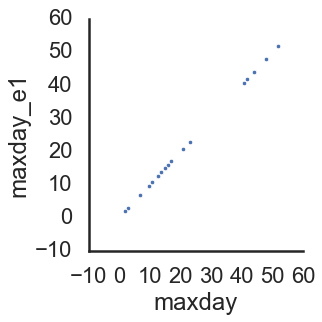

In [35]:
sns.relplot(data=le1df, x='maxday', y='maxday_e1')

In [36]:
sns.set_context('talk')
sns.set_style('white')


In [37]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'L_init', 'e1 coef', 'e1 L_init', 'L_init_e1coef',
       'maxday_e1'],
      dtype='object')

In [38]:
maxdf = df.groupby(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample'])['cells'].max()\
        .reset_index()

Text(0.5,1,'maximum number of cells')

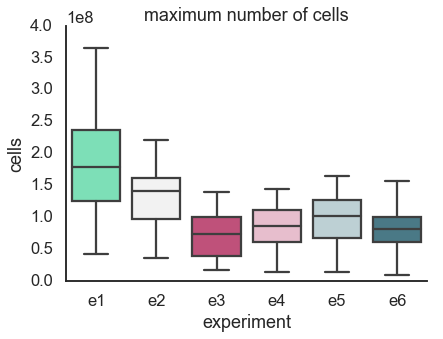

In [39]:
sns.catplot(data=maxdf, x='experiment', y='cells', kind='box', aspect=1.3,
           order=eallorder, palette=eallpallete)
#plt.yscale('log')
plt.title('maximum number of cells')

Text(0.5,1.05,'maximum number of cells')

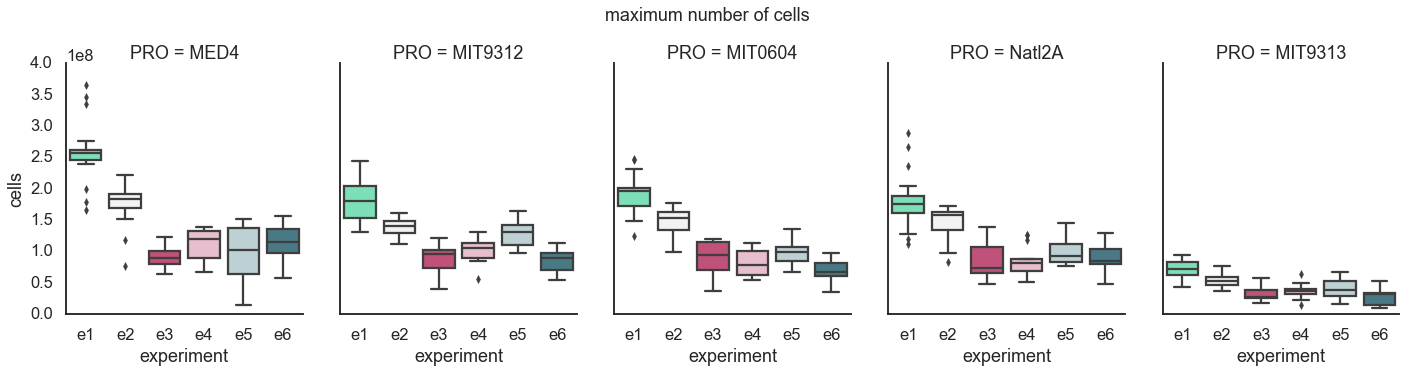

In [40]:
sns.catplot(data=maxdf, x='experiment', y='cells', kind='box', 
           order=eallorder, palette=eallpallete,
            aspect=0.8, height=5,
            col='PRO', col_order=porder)
plt.suptitle('maximum number of cells', y=1.05)
    

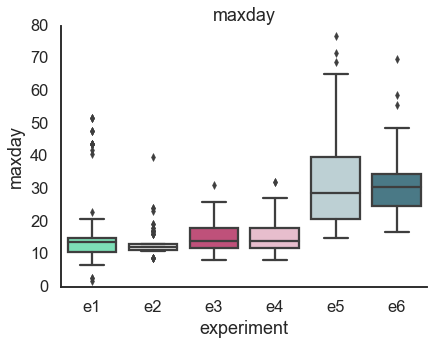

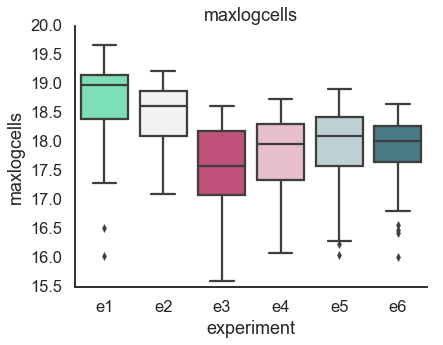

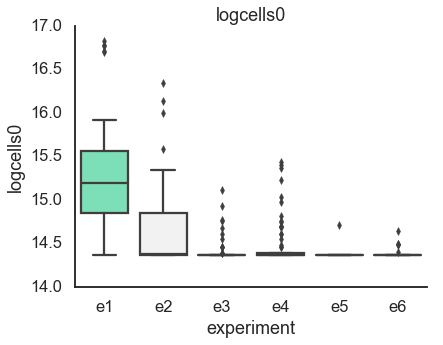

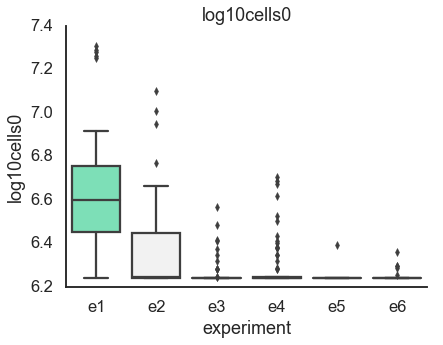

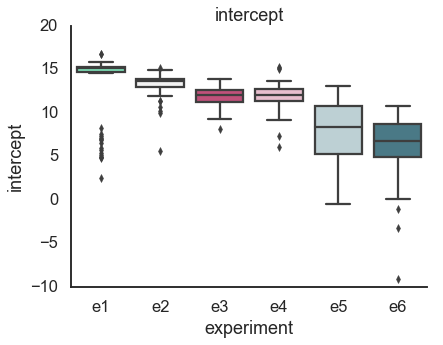

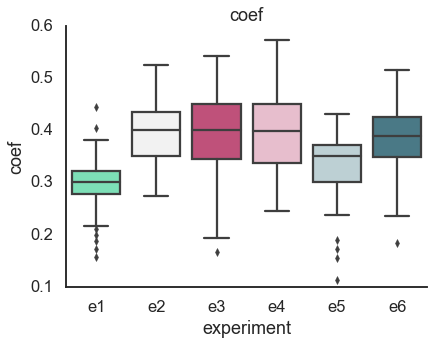

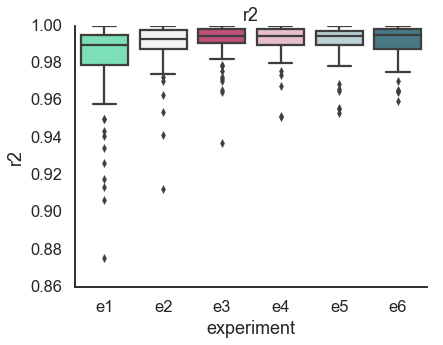

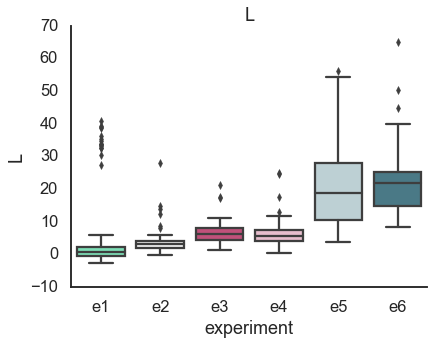

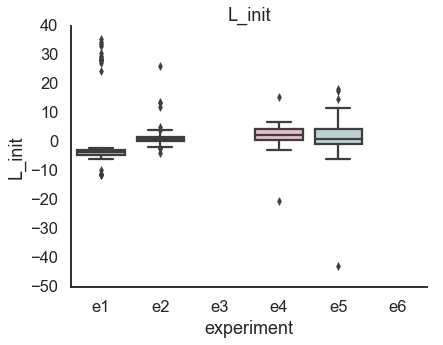

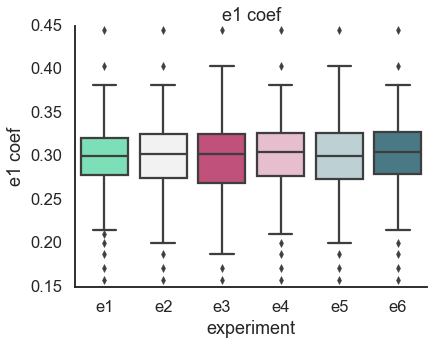

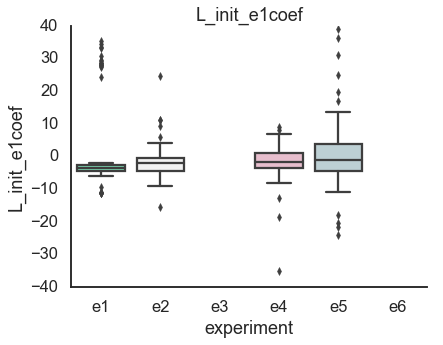

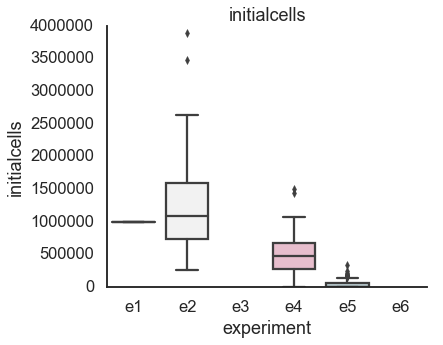

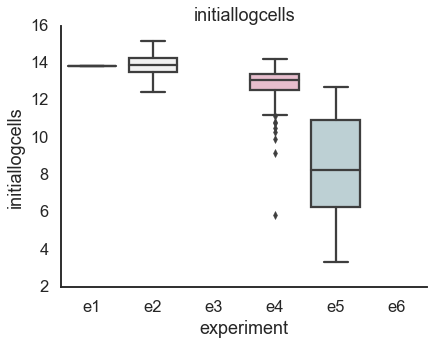

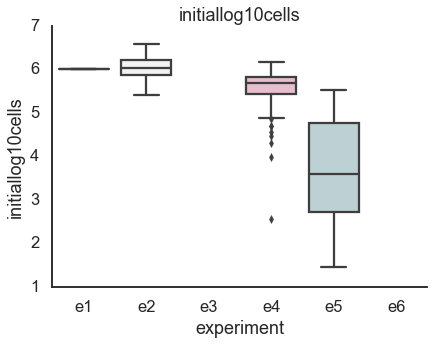

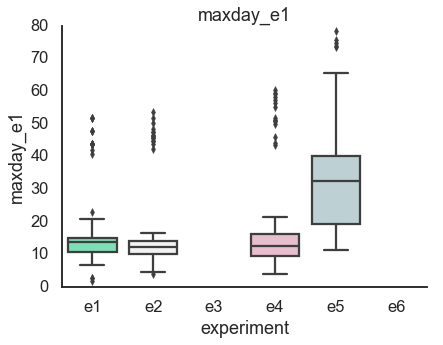

In [41]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L', 
          'L_init', 'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'maxday_e1']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=1.3,
               order=eallorder, palette=eallpallete)
    plt.title(i)

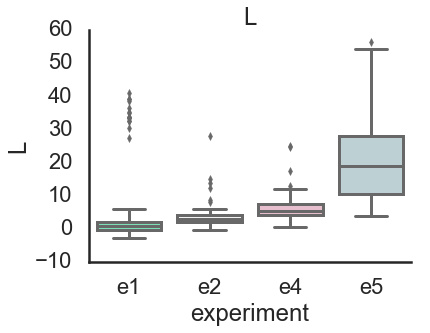

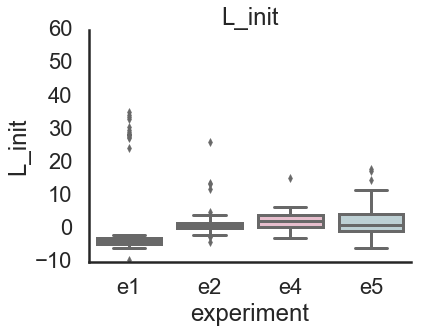

In [42]:
sns.set_style('white')
sns.set_context('poster')
for i in [#'maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 
    'L', 
          'L_init', #'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       #'initiallog10cells', 'maxday_e1'
]:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=1.3, 
                order=efcmorder, palette=efcmpallete,
                facet_kws=dict(ylim=(-10,60))
                
               )
    plt.title(i)

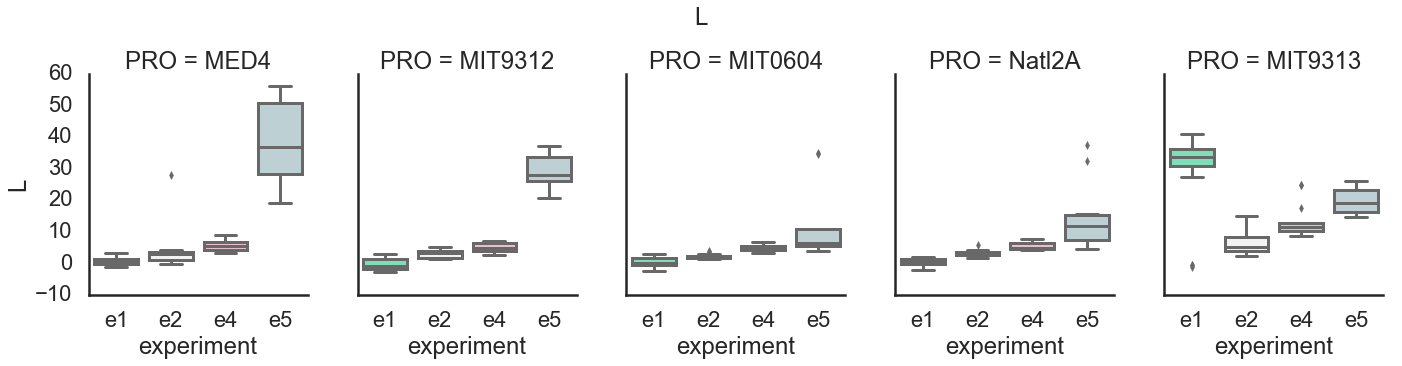

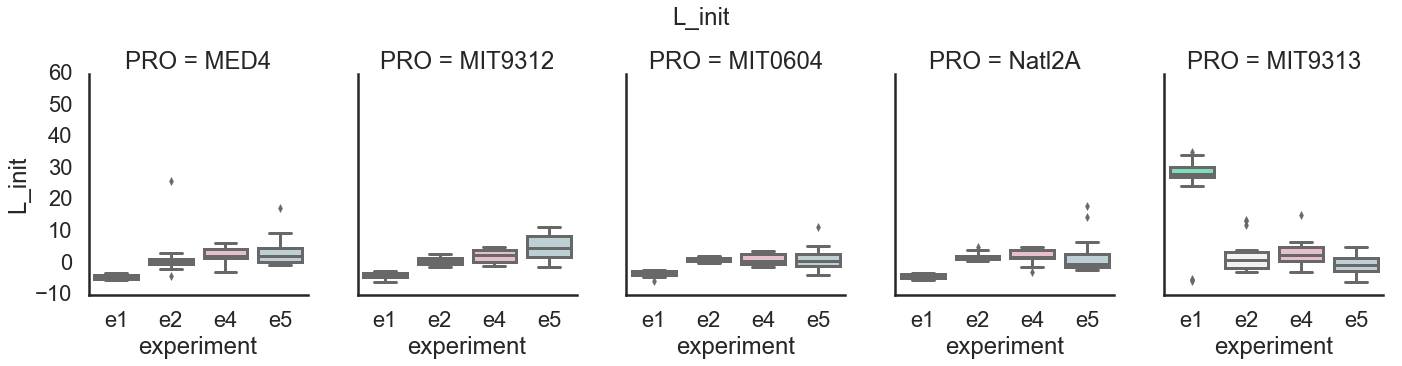

In [43]:
for i in [#'maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2',
    'L', 
          'L_init', #'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       #'initiallog10cells', 'maxday_e1'
]:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=0.8, height=5,
                order=efcmorder,palette=efcmpallete,
                col='PRO', col_order=porder,
                facet_kws=dict(ylim=(-10,60))
               )
    plt.suptitle(i, y=1.05)

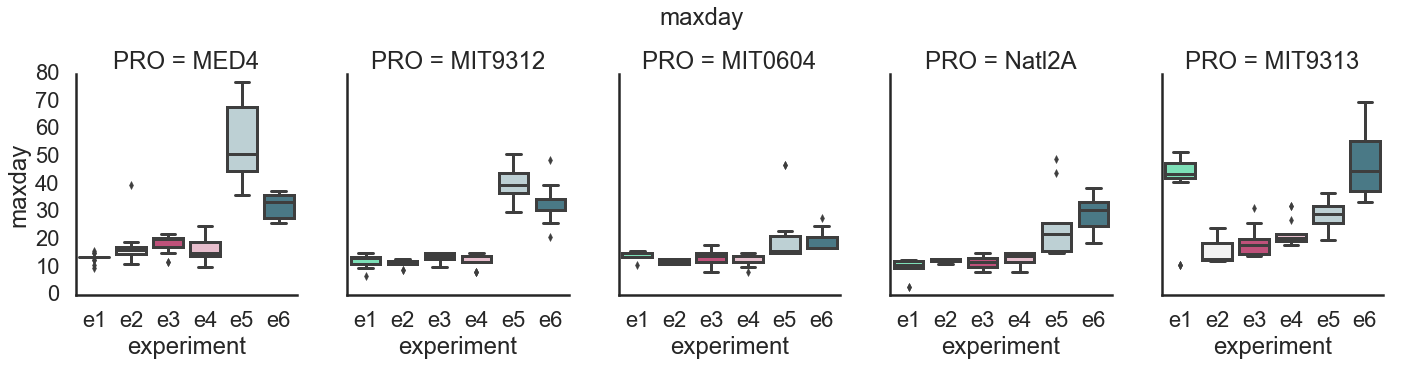

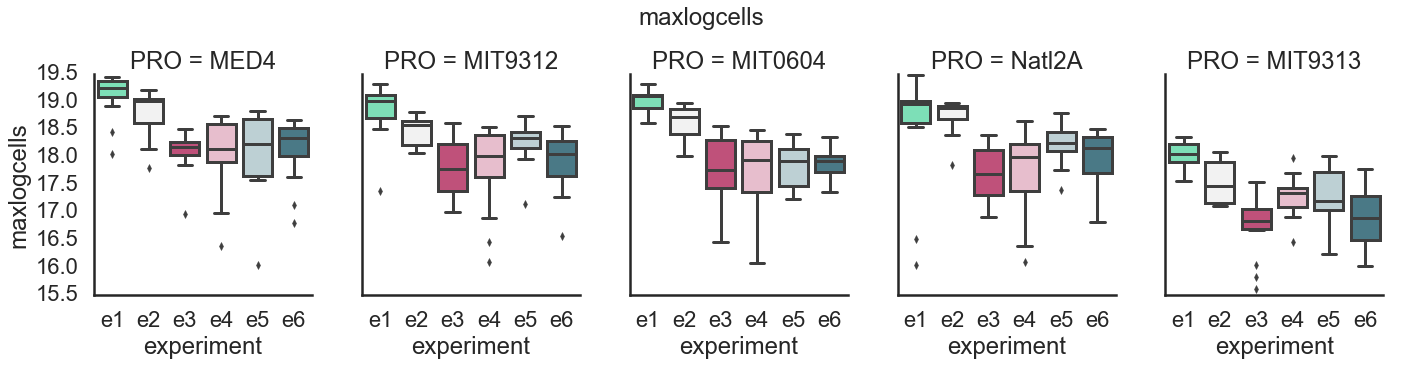

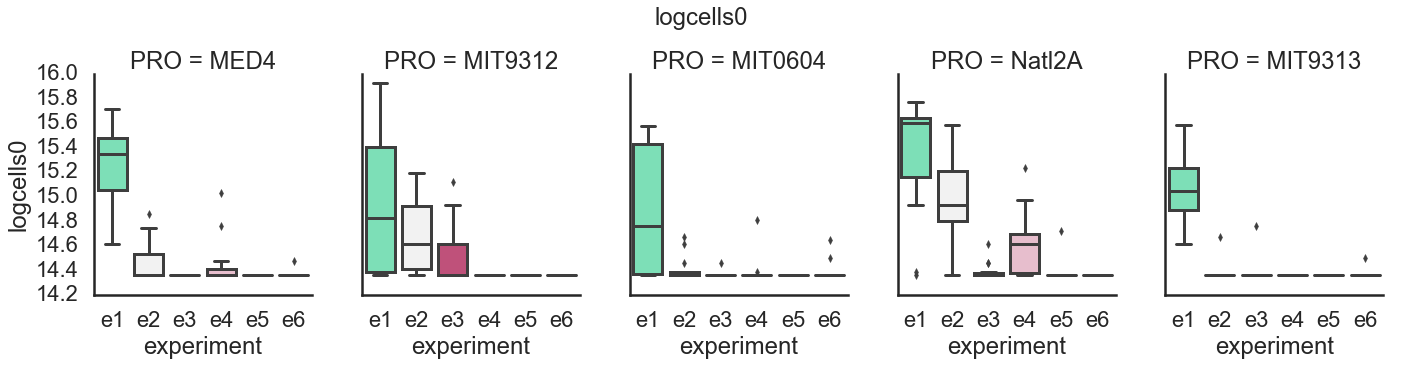

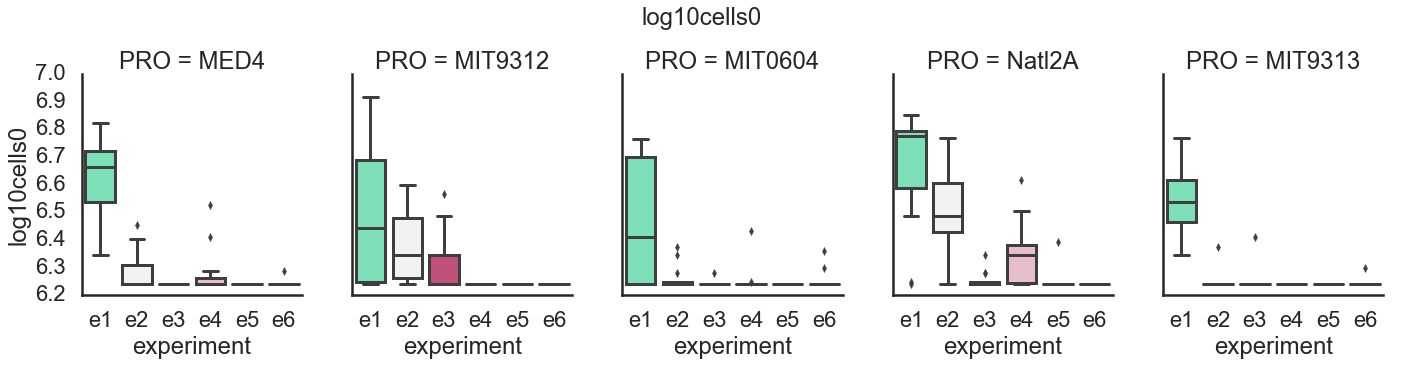

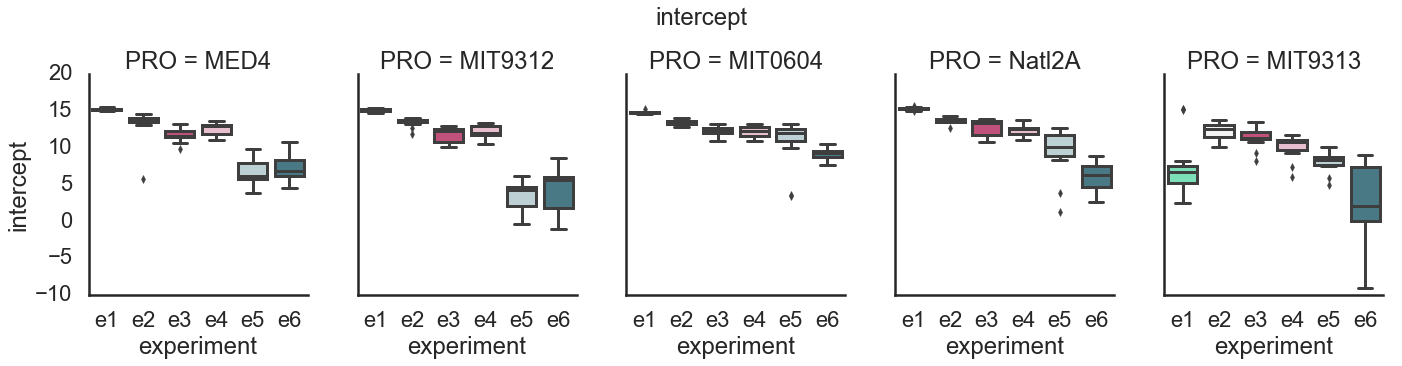

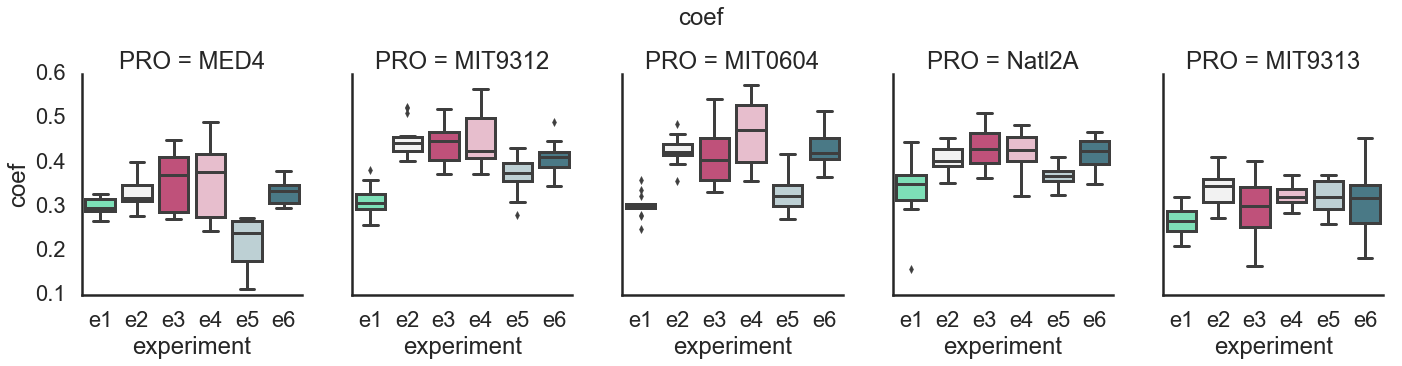

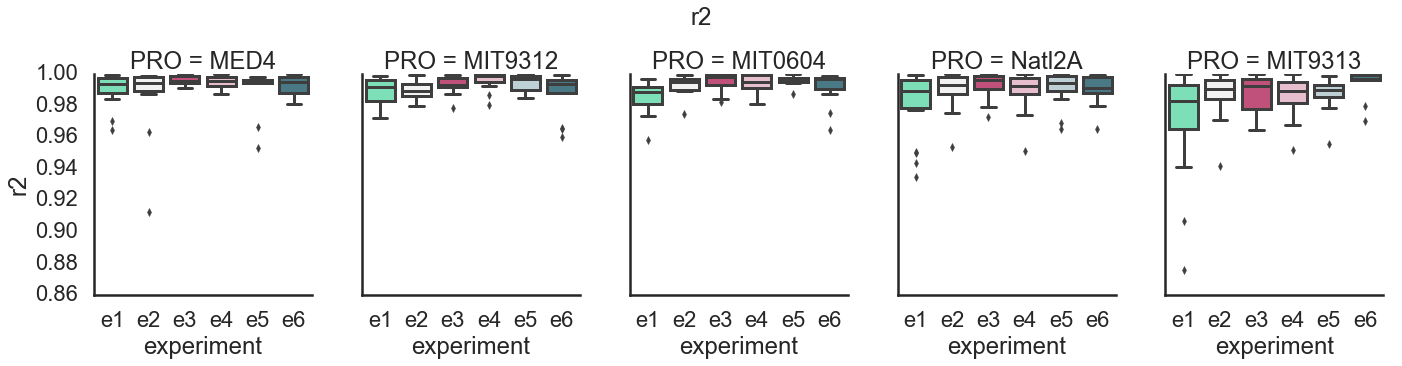

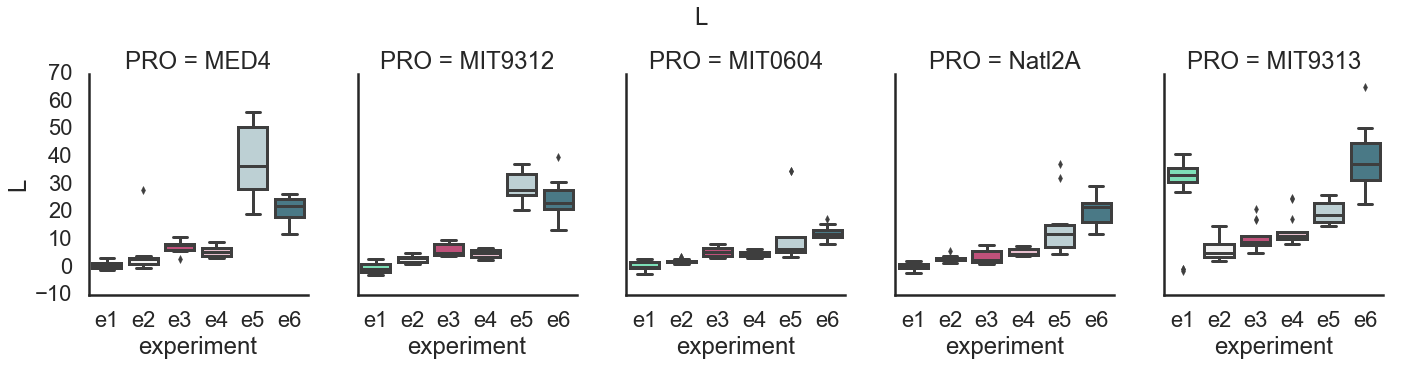

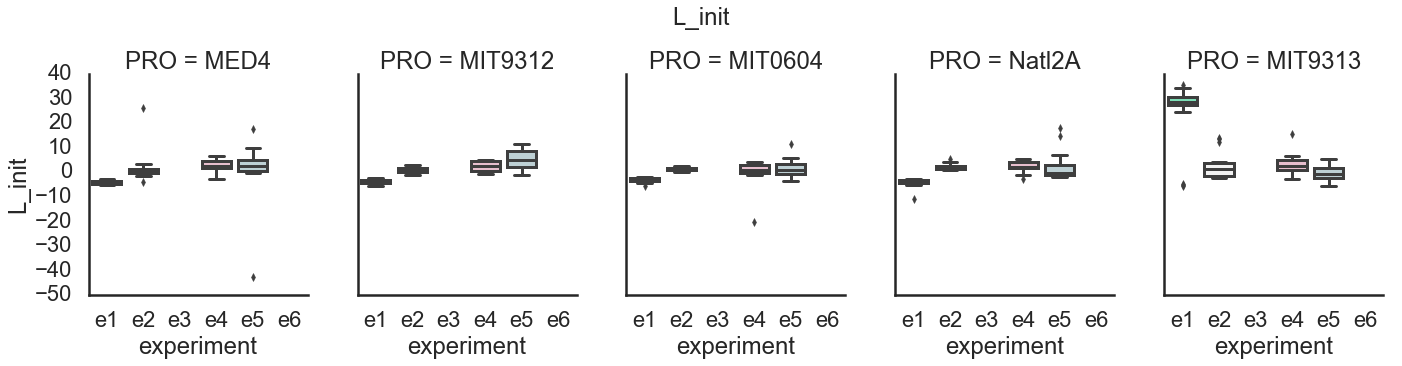

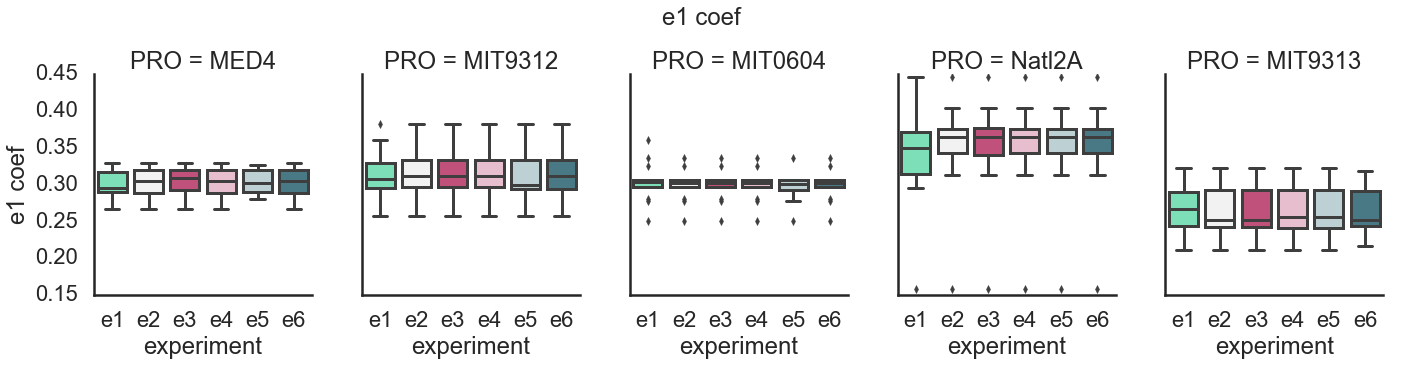

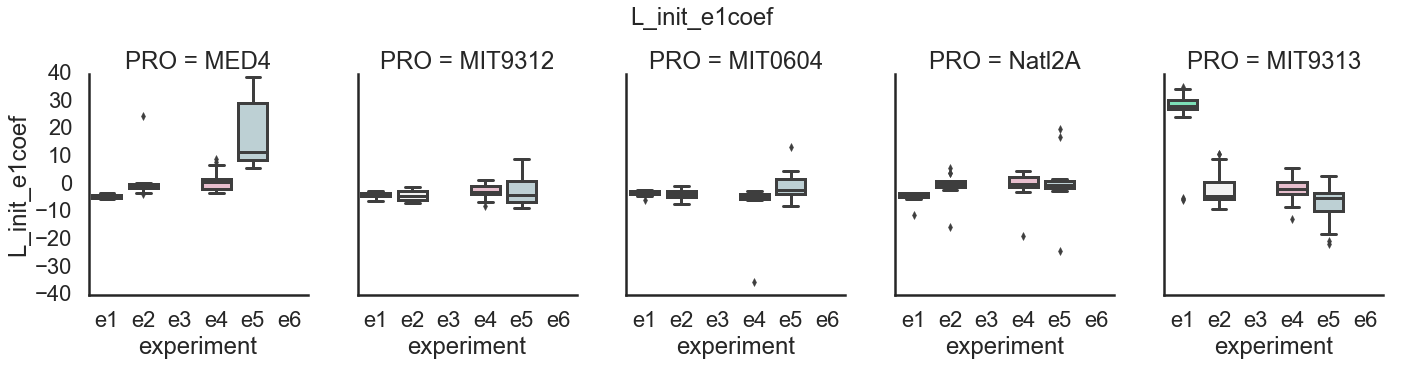

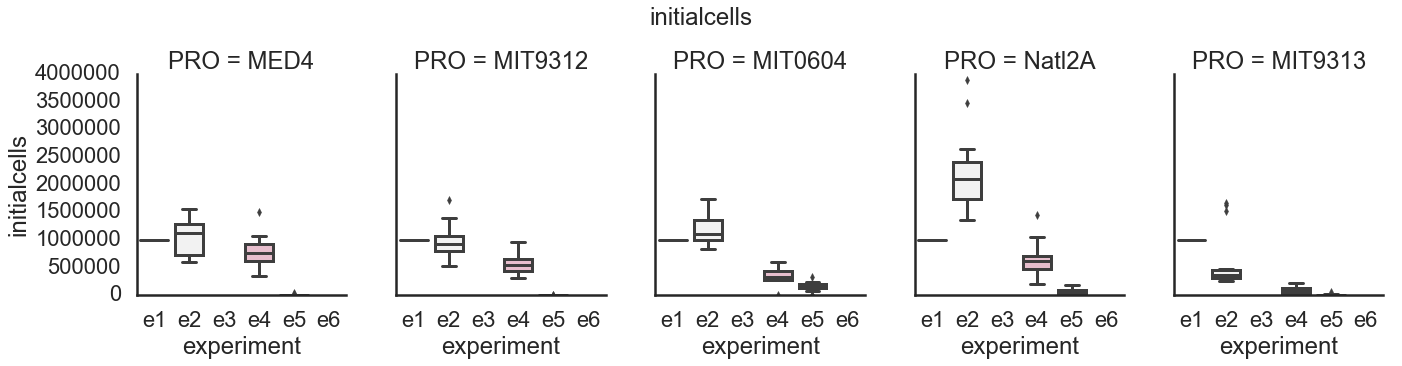

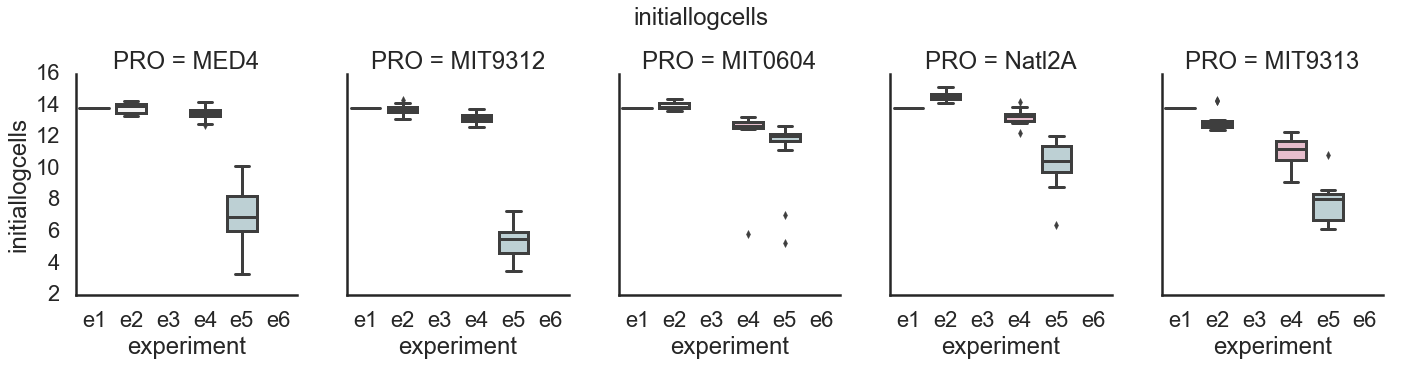

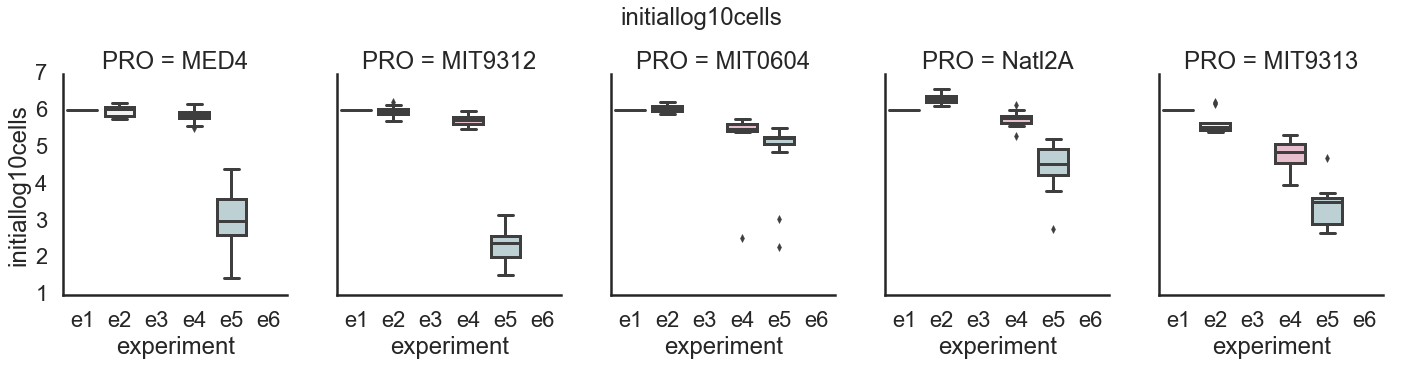

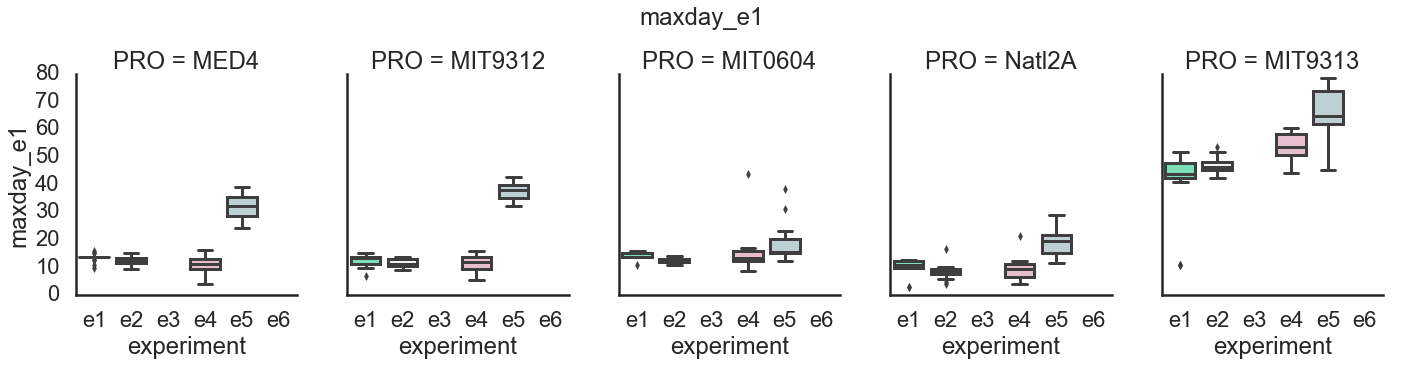

In [44]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L', 
          'L_init', 'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'maxday_e1']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=0.8, height=5,
                order=eallorder,palette=eallpallete,
                
                col='PRO', col_order=porder)
    plt.suptitle(i, y=1.05)

No handles with labels found to put in legend.


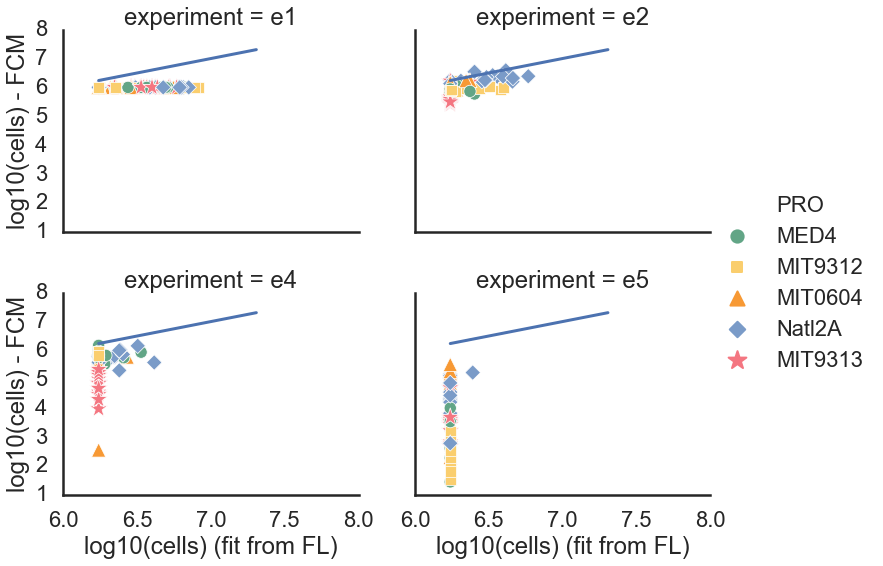

In [45]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='log10cells0', y='initiallog10cells', hue='PRO', 
                height=4, aspect=1,
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                facet_kws=dict(ylim=(1,8), xlim=(6,8), legend_out=True)
            )
g.map(sns.lineplot, x=lagsdf['log10cells0'], y=lagsdf['log10cells0'], linestyle='dashed' )
g.set_axis_labels('log10(cells) (fit from FL)', 'log10(cells) - FCM')
plt.legend(bbox_to_anchor=(1.6,1), frameon=False)

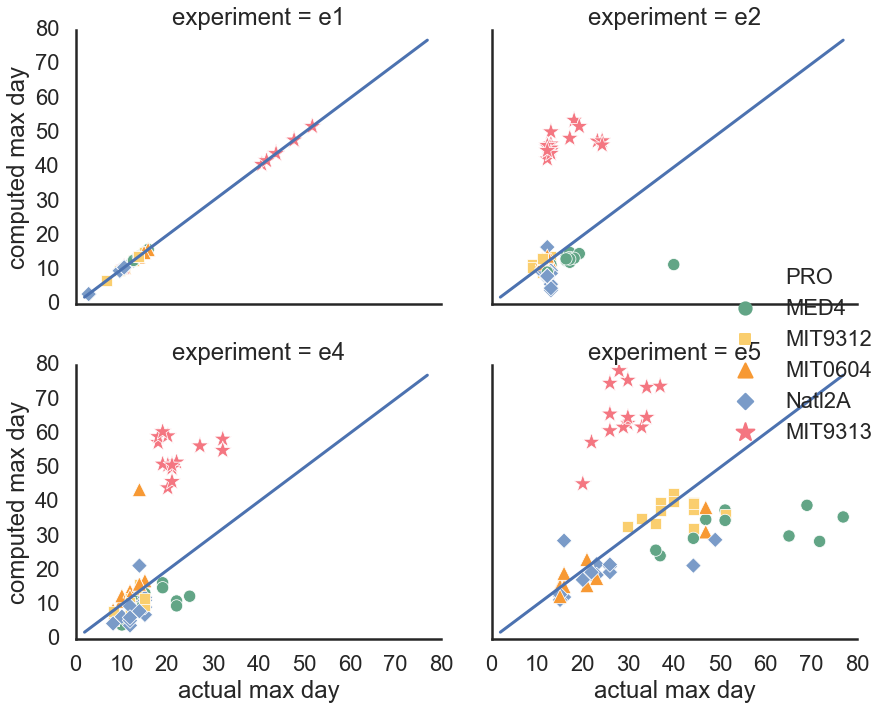

In [46]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='maxday', y='maxday_e1', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                facet_kws=dict(ylim=(0,80), xlim=(0,80))
            )
g.map(sns.lineplot, x=lagsdf['maxday'], y=lagsdf['maxday'], linestyle='dashed' )
g.set_axis_labels('actual max day', 'computed max day')


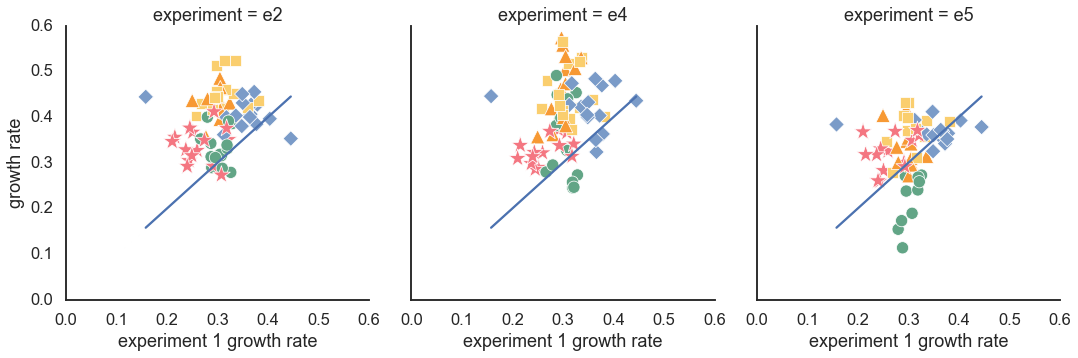

In [82]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
sns.set_context('talk')
sns.set_style('white')
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='e1 coef', y='coef', hue='PRO', 
            col='experiment', #col_wrap=2,
                col_order=['e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6)),
                legend=False
                
            )
g.map(sns.lineplot, x=lagsdf['e1 coef'], y=lagsdf['e1 coef'], linestyle='dashed' )
g.set_axis_labels('experiment 1 growth rate', 'growth rate')
#plt.legend(False)

In [48]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'L_init', 'e1 coef', 'e1 L_init', 'L_init_e1coef',
       'maxday_e1'],
      dtype='object')

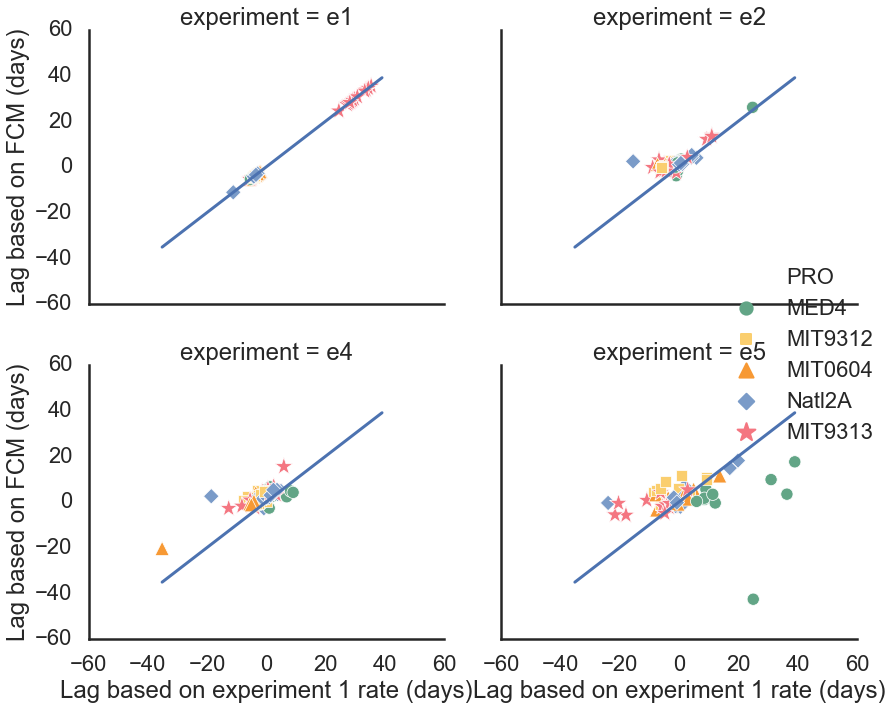

In [49]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='L_init_e1coef', y='L_init', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6))
            )
g.map(sns.lineplot, x=lagsdf['L_init_e1coef'], y=lagsdf['L_init_e1coef'], linestyle='dashed' )
g.set_axis_labels('Lag based on experiment 1 rate (days)', 'Lag based on FCM (days)')


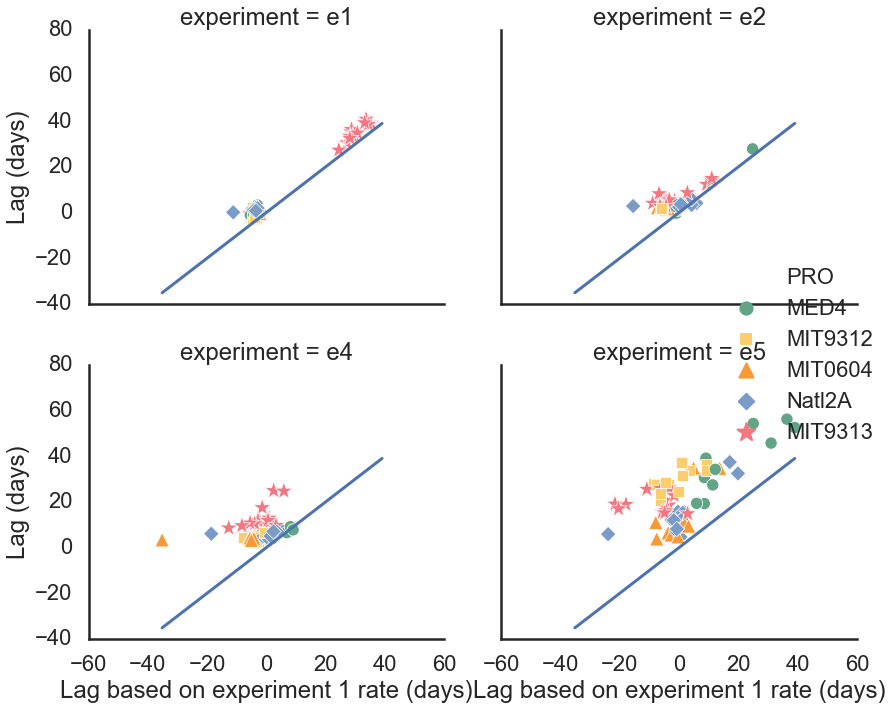

In [50]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='L_init_e1coef', y='L', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6))
            )
g.map(sns.lineplot, x=lagsdf['L_init_e1coef'], y=lagsdf['L_init_e1coef'], linestyle='dashed' )
g.set_axis_labels('Lag based on experiment 1 rate (days)', 'Lag (days)')


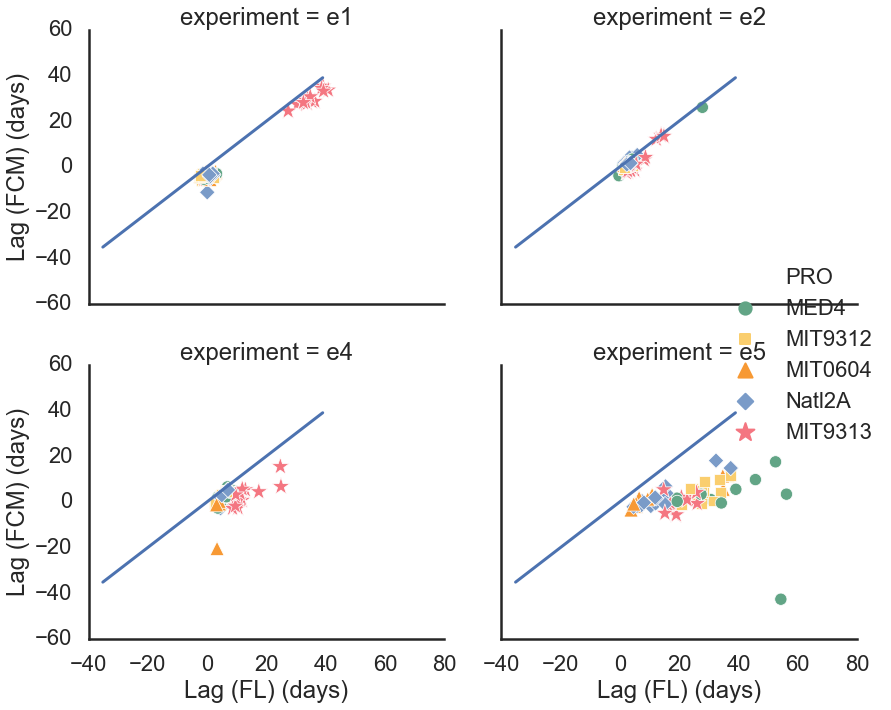

In [51]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='L', y='L_init', hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, hue_order=porder,
                style='PRO', style_order=porder, markers=pmarkers,
                size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,0.6), xlim=(0,0.6))
            )
g.map(sns.lineplot, x=lagsdf['L_init_e1coef'], y=lagsdf['L_init_e1coef'], linestyle='dashed' )
g.set_axis_labels('Lag (FL) (days)', 'Lag (FCM) (days)')


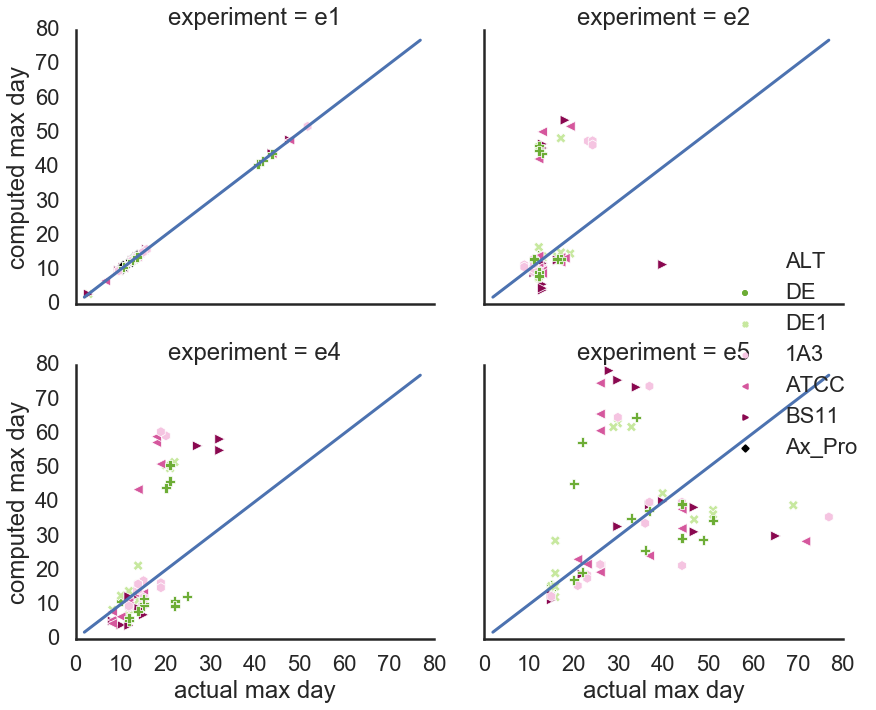

In [52]:
#for e in ['e1', 'e2', 'e4', 'e5']: 
g = sns.relplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='maxday', y='maxday_e1', hue='ALT', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=apallete + ['black'], hue_order=aorder + ['Ax_Pro'],
                s=100,
                style='ALT', style_order=aorder+ ['Ax_Pro'], markers=amarkers + ['D'],
                facet_kws=dict(ylim=(0,80), xlim=(0,80))
            )
g.map(sns.lineplot, x=lagsdf['maxday'], y=lagsdf['maxday'], linestyle='dashed' )
g.set_axis_labels('actual max day', 'computed max day')


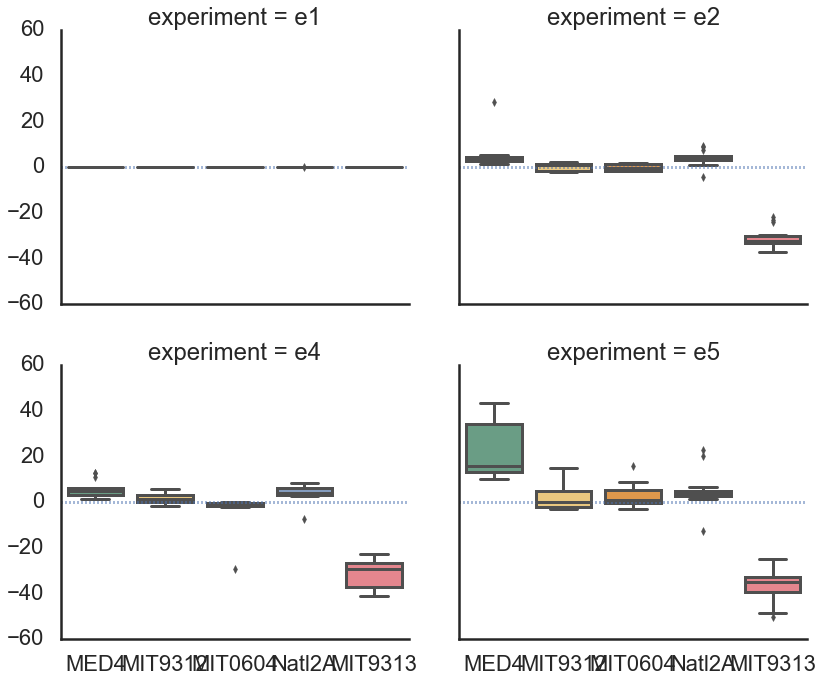

In [53]:
lagsdf['max day diff (actual - computed)'] = lagsdf['maxday'] - lagsdf['maxday_e1']
g = sns.catplot(data=lagsdf.loc[lagsdf.culture.isin(['Co_Culture', 'Axenic'])], 
                                x='PRO', y='max day diff (actual - computed)', #hue='PRO', 
            col='experiment', col_wrap=2, col_order=['e1', 'e2', 'e4', 'e5'], 
                palette=ppallete, order=porder,
                aspect=1.2,
                #style='PRO', style_order=porder, markers=pmarkers,
                #size='PRO', size_order=porder, sizes=psizes,
                #facet_kws=dict(ylim=(0,80))
                kind='box',
            )
def plot_axhline0(**kwargs):
    plt.axhline(0,**kwargs)
g.map(plot_axhline0, ls=':')


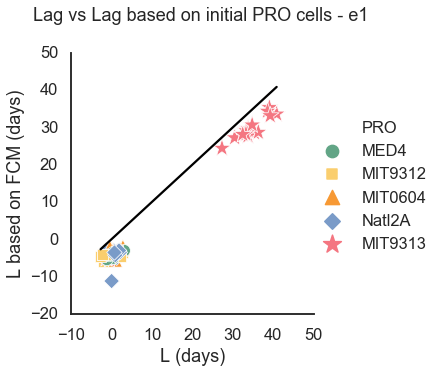

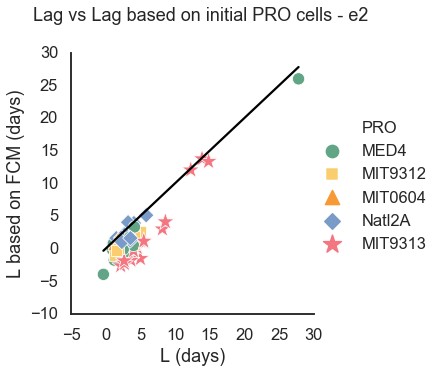

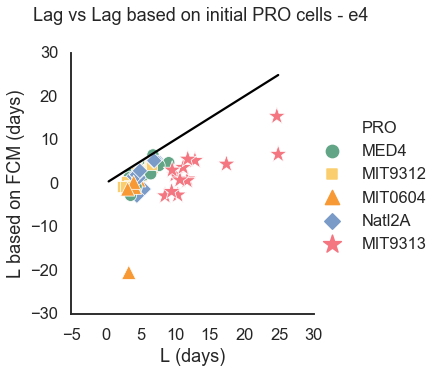

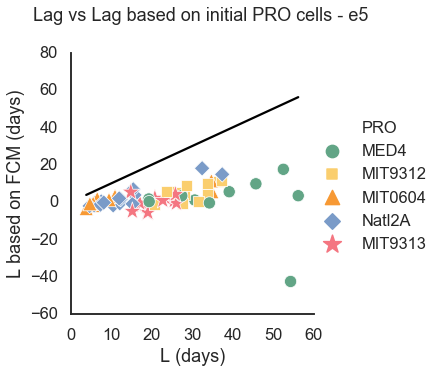

In [54]:
sns.set_context('talk')
sns.set_style('white')
for e in ['e1','e2','e4','e5']:
    g = sns.relplot(data=lagsdf.loc[lagsdf.experiment.isin([e]) & lagsdf.PRO.isin(porder)], 
            x='L', y='L_init',  hue='PRO', s=50, #legend=False,
                    hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, markers=pmarkers,
                    size='PRO', size_order=porder, sizes=psizes,
                   )
    sns.lineplot(x=lagsdf.loc[lagsdf.experiment.isin([e]),'L'], 
                 y=lagsdf.loc[lagsdf.experiment.isin([e]),'L'], color='black', ax=g.ax, legend=False )
    g.set_axis_labels('L (days)', 'L based on FCM (days)')
    plt.suptitle(f'Lag vs Lag based on initial PRO cells - {e}', y=1.05)

In [55]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'L_init', 'e1 coef', 'e1 L_init', 'L_init_e1coef',
       'maxday_e1', 'max day diff (actual - computed)'],
      dtype='object')

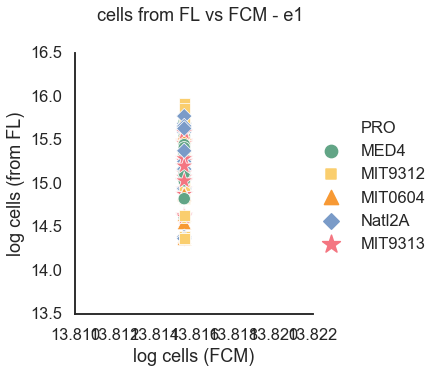

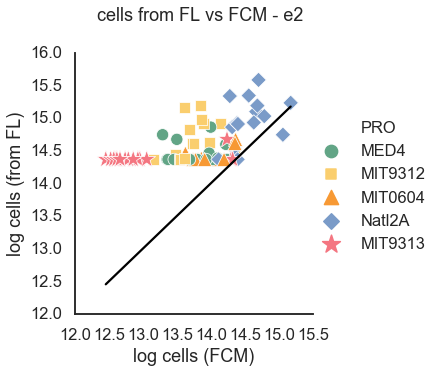

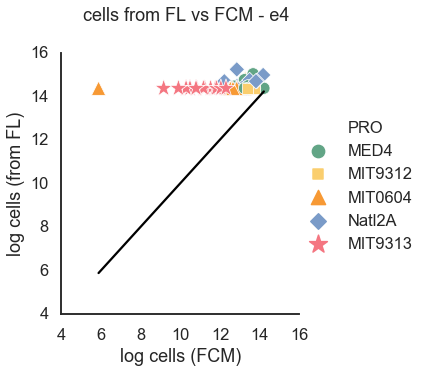

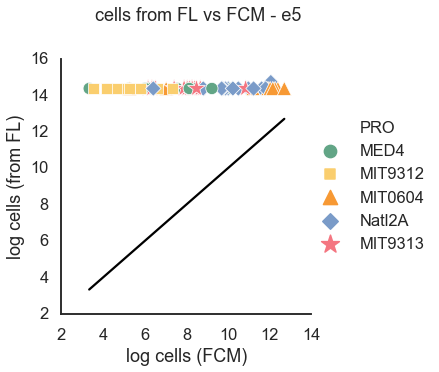

In [56]:
sns.set_context('talk')
sns.set_style('white')
for e in ['e1','e2','e4','e5']:
    g = sns.relplot(data=lagsdf.loc[lagsdf.experiment.isin([e]) & lagsdf.PRO.isin(porder)], 
            y='logcells0', x='initiallogcells',  hue='PRO', s=50, #legend=False,
                    hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, markers=pmarkers,
                    size='PRO', size_order=porder, sizes=psizes,
                   )
    sns.lineplot(x=lagsdf.loc[lagsdf.experiment.isin([e]),'initiallogcells'], 
                 y=lagsdf.loc[lagsdf.experiment.isin([e]),'initiallogcells'], color='black', ax=g.ax, legend=False )
    g.set_axis_labels('log cells (FCM)', 'log cells (from FL)', )
    plt.suptitle(f'cells from FL vs FCM - {e}', y=1.05)
    plt.ticklabel_format(useOffset=False)

In [57]:
worse_l = lagsdf.nsmallest(10, 'L')['experiment_sample']

In [58]:
lagsdf.nsmallest(10, 'r2')

experiment sample      PRO      ALT      culture experiment_sample  \
41          e1    22C  MIT9313     ATCC   Co_Culture           e1, 22C   
6           e1    12A  MIT9313      DE1   Co_Culture           e1, 12A   
94          e2    11A     MED4      DE1   Co_Culture           e2, 11A   
68          e1    37B      all      all  All_strains           e1, 37B   
67          e1    37A      all      all  All_strains           e1, 37A   
69          e1    37C      all      all  All_strains           e1, 37C   
47          e1    24C   Natl2A     ATCC   Co_Culture           e1, 24C   
219         e3    36B     allP  all_Pro      All_Pro           e3, 36B   
58          e1    29C  MIT9313   Ax_Pro       Axenic           e1, 29C   
140         e2     2A  MIT9313      1A3   Co_Culture            e2, 2A   

        maxday     minday  maxlogcells  logcells0  ...          L  \
41   47.781250  33.886111    17.932665  14.871641  ...  33.229358   
6    43.836806  33.886111    17.989164  14.627188  ...  30.432765   
94   16.310000   4.110000    19.008445  14.364823  ...  -0.337673   
68   20.660417   0.000000    19.483775  16.695024  ...   5.785277   
67   22.951389   0.000000    19.660036  16.714292  ...   5.803273   
69   16.952083   0.000000    19.427418  16.826120  ...   3.930518   
47   10.603472   0.000000    18.599220  15.162331  ...  -0.392776   
219  11.910000   4.910000    16.607659  14.364823  ...   5.737224   
58   10.603472   0.000000    18.228916  15.197733  ...  -0.508558   
140  23.160000  12.990000    17.686978  14.364823  ...  12.256379   

     initialcells  initiallogcells  initiallog10cells     L_init   e1 coef  \
41   1.000000e+06        13.815511           6.000000  28.208587  0.210352   
6    1.000000e+06        13.815511           6.000000  27.196647  0.250818   
94   6.310714e+05        13.355174           5.800079  -3.957328  0.326145   
68   1.000000e+06        13.815511           6.000000  -9.573985  0.187477   
67   1.000000e+06        13.815511           6.000000 -11.071461  0.171782   
69   1.000000e+06        13.815511           6.000000 -11.139976  0.199768   
47   1.000000e+06        13.815511           6.000000  -4.701897  0.312551   
219           NaN              NaN                NaN        NaN  0.261473   
58   1.000000e+06        13.815511           6.000000  -5.575653  0.272784   
140  1.618456e+06        14.296983           6.209101  12.033721  0.243284   

     e1 L_init  L_init_e1coef  maxday_e1  max day diff (actual - computed)  
41   28.208587      28.208587  47.781250                          0.000000  
6    27.196647      27.196647  43.836806                          0.000000  
94   -3.565282      -1.023601  13.768319                          2.541681  
68   -9.573985      -9.573985  20.660417                          0.000000  
67  -11.071461     -11.071461  22.951389                          0.000000  
69  -11.139976     -11.139976  16.952083                          0.000000  
47   -4.701897      -4.701897  10.603472                          0.000000  
219 -11.342369            NaN        NaN                               NaN  
58   -5.575653      -5.575653  10.603472                          0.000000  
140  33.554652       9.225678  47.488974                        -24.328974  

[10 rows x 24 columns]

In [59]:
def plot_growth(es):
    sns.set(rc={'figure.figsize':(10,5)})
    maxday = lagsdf.loc[lagsdf.experiment_sample == es, 'maxday'].unique()[0]
    minday = lagsdf.loc[lagsdf.experiment_sample == es, 'minday'].unique()[0]
    r2 = lagsdf.loc[lagsdf.experiment_sample == es, 'r2'].unique()[0]
    L = lagsdf.loc[lagsdf.experiment_sample == es, 'L'].unique()[0]
    
    d = df.loc[df.experiment_sample == es].reset_index()
    d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    sns.lineplot(data=d,
                 x='day', y='logcells',  style=True, markers=True,label='logcells')
    sns.lineplot(data=d,
        x='day', y='fitted_growth',  style=True, markers=True,label='fit')
    plt.title(f'{es}: L={L:.2f}, r2={r2:.2f}')
    plt.show()


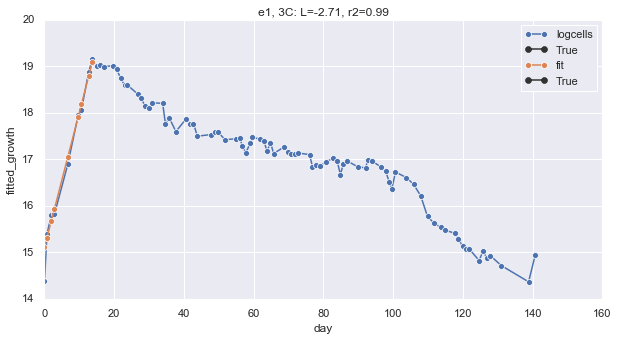

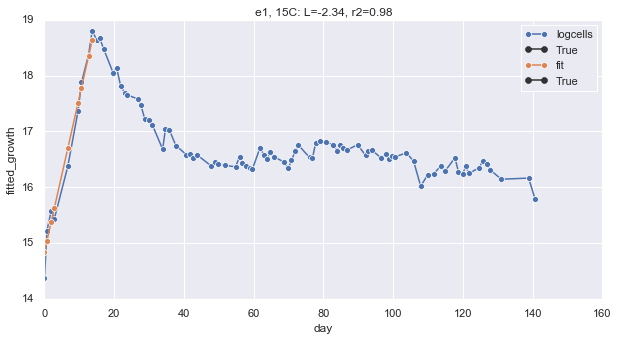

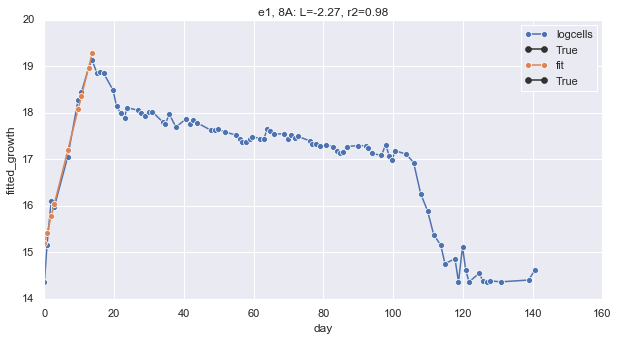

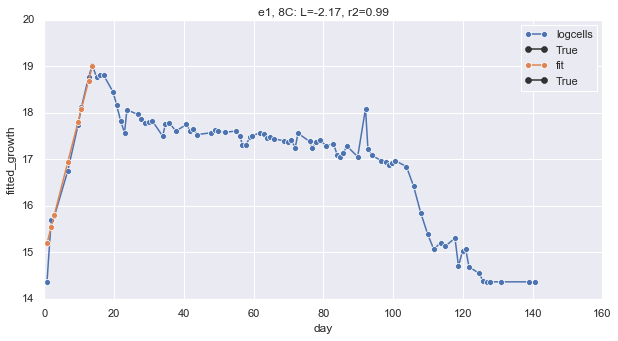

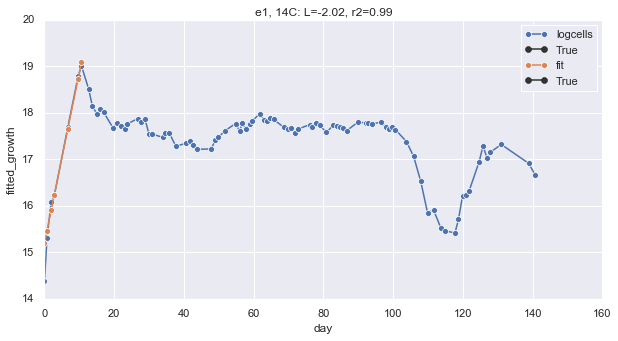

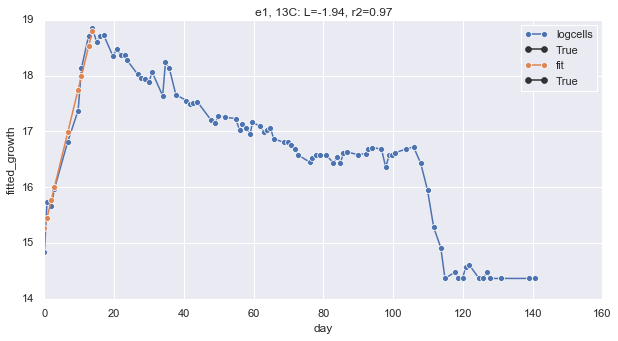

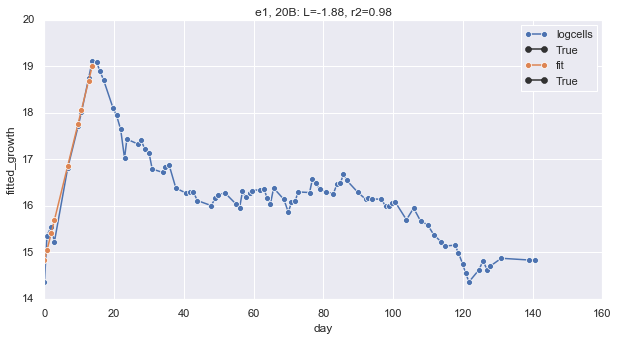

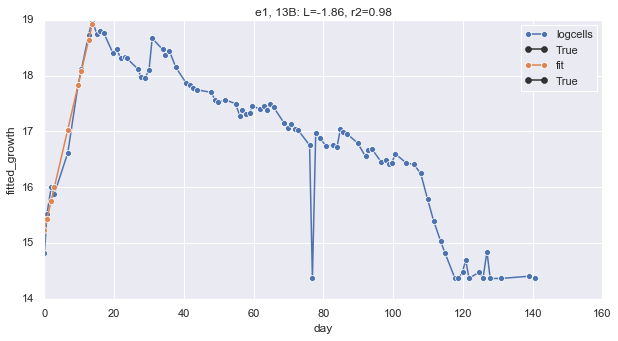

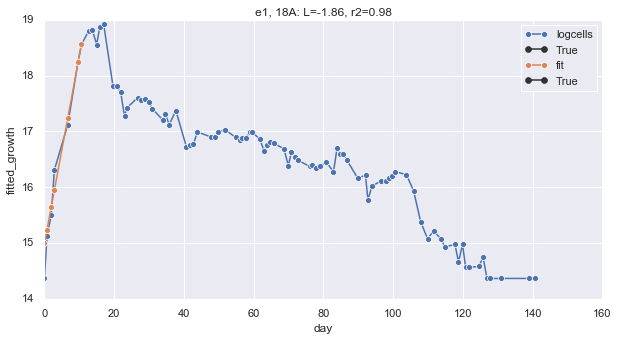

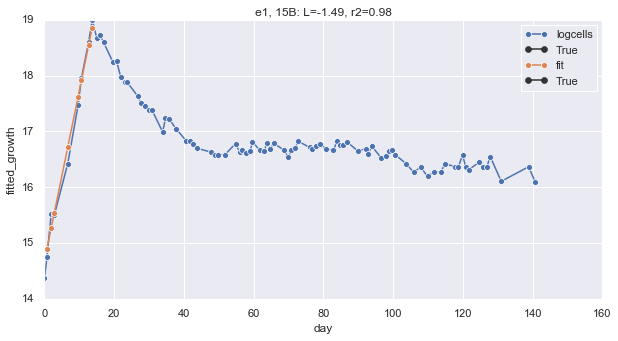

In [60]:
for es in worse_l:
    plot_growth(es)

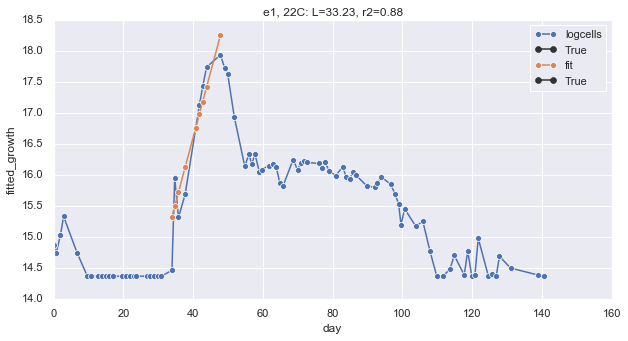

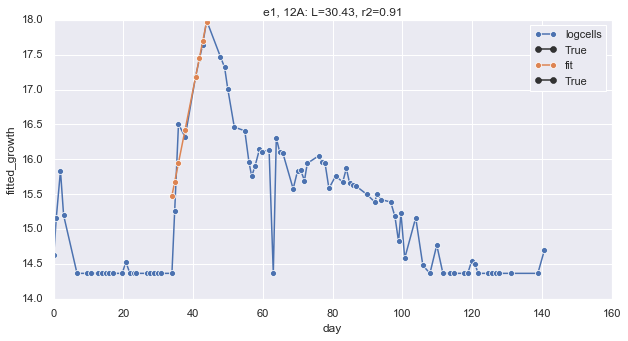

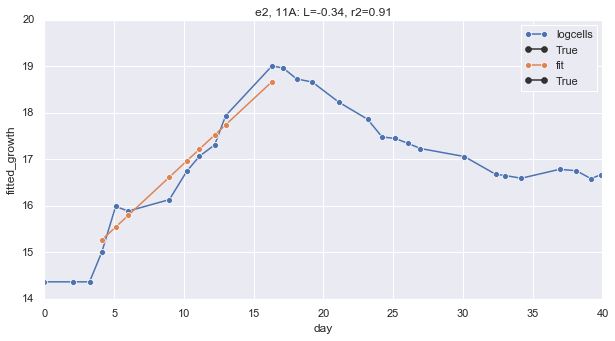

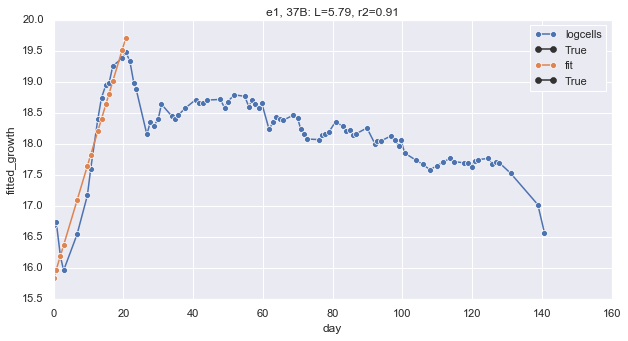

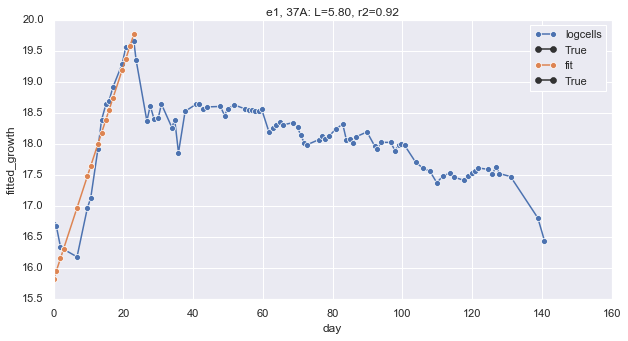

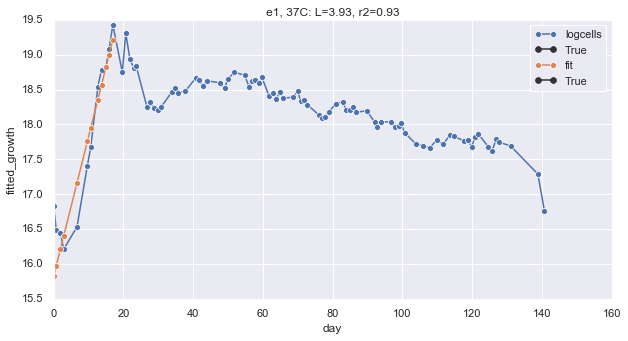

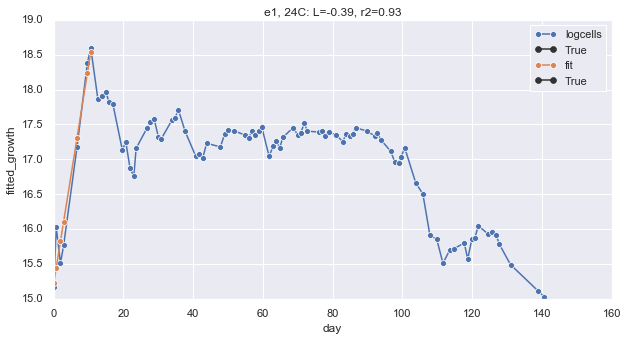

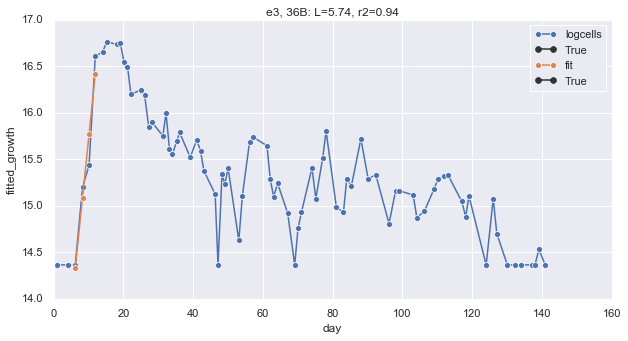

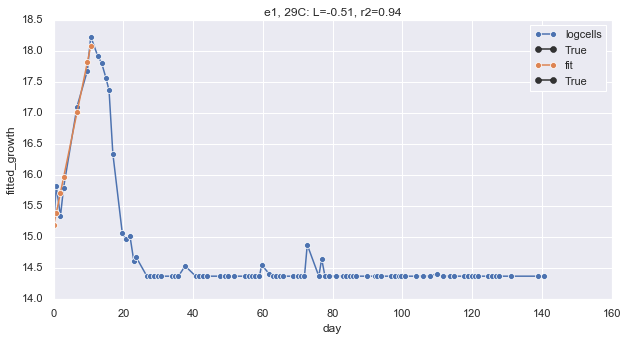

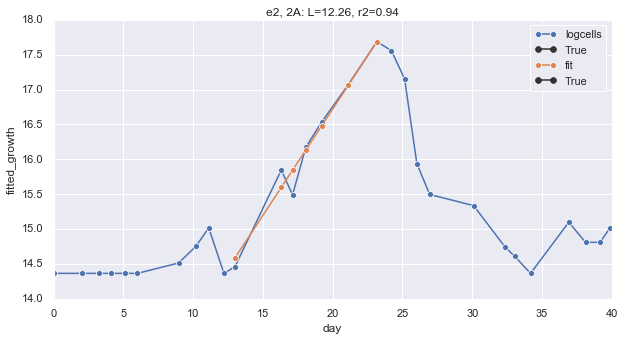

In [61]:
worse_r2 = lagsdf.nsmallest(10, 'r2')['experiment_sample']
for es in worse_r2:
    plot_growth(es)

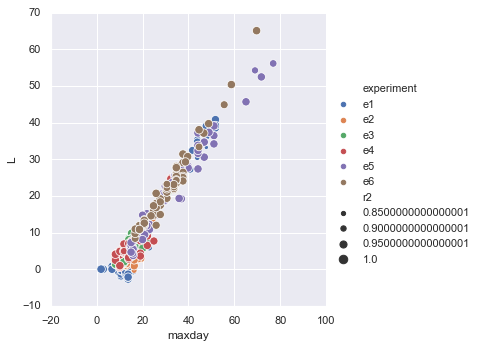

In [62]:
sns.relplot(data=lagsdf, x='maxday', y='L', hue='experiment', size='r2')

In [63]:
lagsdf.loc[lagsdf.maxday>60]

experiment sample      PRO   ALT     culture experiment_sample  maxday  \
325         e5    11C     MED4   DE1  Co_Culture           e5, 11C   69.01   
337         e5    16B     MED4  BS11  Co_Culture           e5, 16B   65.08   
347         e5     1C     MED4   1A3  Co_Culture            e5, 1C   76.94   
350         e5    21B     MED4  ATCC  Co_Culture           e5, 21B   71.78   
410         e6    17A  MIT9313  BS11  Co_Culture           e6, 17A   69.70   

     minday  maxlogcells  logcells0  ...          L  initialcells  \
325   61.86    16.043787  14.364823  ...  54.259495     28.000000   
337   48.95    18.037574  14.364823  ...  45.684519   1900.538748   
347   61.86    17.575667  14.364823  ...  56.151397    495.000000   
350   54.95    17.709803  14.364823  ...  52.474450   4023.207626   
410   62.70    16.021145  14.364823  ...  65.097281           NaN   

     initiallogcells  initiallog10cells     L_init   e1 coef  e1 L_init  \
325         3.332205           1.447158 -42.667360  0.288518  -5.097853   
337         7.549893           3.278877   9.695449  0.307401  -4.106603   
347         6.204558           2.694605   3.317767  0.279830  -5.079360   
350         8.299835           3.604572  17.470368  0.286681  -4.392570   
410              NaN                NaN        NaN  0.245185  28.537181   

     L_init_e1coef  maxday_e1  max day diff (actual - computed)  
325      24.951764  38.960383                         30.049617  
337      30.962762  30.010635                         35.069365  
347      36.304159  35.556480                         41.383520  
350      38.956188  28.431242                         43.348758  
410            NaN        NaN                               NaN  

[5 rows x 24 columns]

In [64]:
def plot_growth(es):
    maxday = lagsdf.loc[lagsdf.experiment_sample == es, 'maxday'].unique()[0]
    minday = lagsdf.loc[lagsdf.experiment_sample == es, 'minday'].unique()[0]
    r2 = lagsdf.loc[lagsdf.experiment_sample == es, 'r2'].unique()[0]
    L = lagsdf.loc[lagsdf.experiment_sample == es, 'L'].unique()[0]
    
    d = df.loc[df.experiment_sample == es].reset_index()
    d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    sns.lineplot(data=d,
                 x='day', y='logcells',  style=True, markers=True,label='logcells')
    sns.lineplot(data=d,
        x='day', y='fitted_growth',  style=True, markers=True,label='fit')
    plt.title(f'{es}: L={L:.2f}, r2={r2:.2f}')
    plt.show()


In [65]:
def add_fit(d):
    es = d.name
    lagsdf_row = lagsdf.loc[lagsdf.experiment_sample == es].iloc[0]
    maxday = lagsdf_row['maxday']
    minday = lagsdf_row['minday']
    coef = lagsdf_row['coef']
    intercept = lagsdf_row['intercept']
    
    d['fitted_growth'] = d.day*coef + intercept
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    return d
    

df_fit = df.reset_index(drop=True).groupby(['experiment_sample']).apply(add_fit)


In [66]:
df_fit.columns

Index(['day', 'experiment', 'sample', 'FL', 'PRO', 'ALT', 'culture', 'FL_orig',
       'logFL', 'cumsumFL', 'cumsumlogFL', 'zscoreFL', 'diffFL', 'difflogFL',
       'diffday', 'rateFL', 'ratelogFL', 'experiment_sample', 'cells',
       'logcells', 'fitted_growth'],
      dtype='object')

In [67]:
df_fit_m = df_fit.melt(id_vars=['day', 'experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample'],
            value_vars=['logcells', 'fitted_growth'], value_name='ln(cell/ml)', var_name='var' )

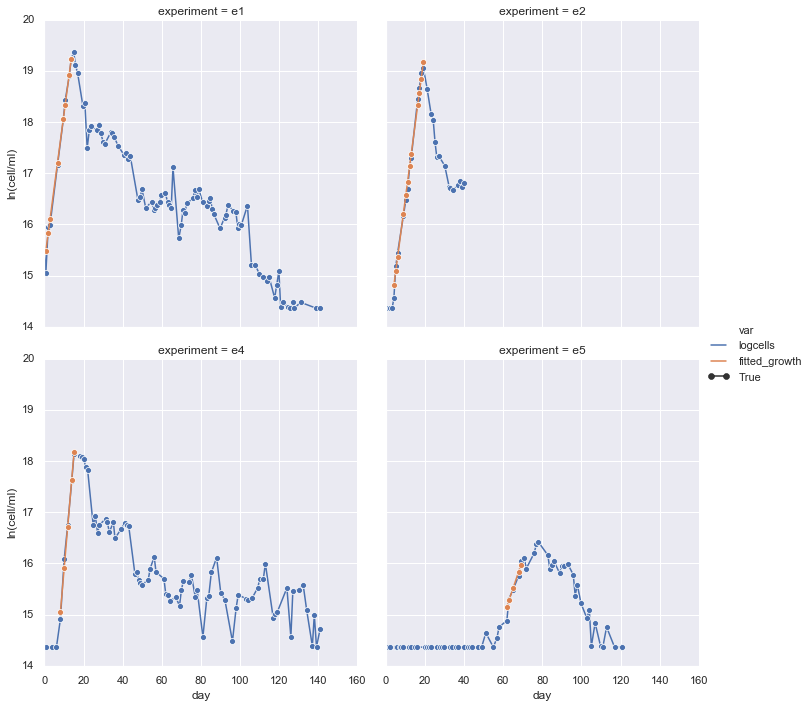

In [68]:

g = sns.relplot(data=df_fit_m.loc[df_fit_m['sample'].isin(['11C']) &
                               df_fit_m.experiment.isin(['e1','e2','e4','e5'])],
             x='day', y='ln(cell/ml)', hue='var',
                style=True, markers=True, col='experiment', col_wrap=2, kind='line')



In [69]:
with pd.option_context("display.precision", 2,):
    display(lagsdf.loc[lagsdf['sample'].isin(['11C'])&
           lagsdf.experiment.isin(['e1','e2','e4','e5']),]
                       
#           #['experiment', 
#         'log10cells0', 'initiallog10cells',
#        'coef', 'r2', 'L', 
#        'L_init', 'L_init_e1coef', 
#       'maxday', 'maxday_e1', ]]
           )

experiment sample   PRO  ALT     culture experiment_sample  maxday  \
5           e1    11C  MED4  DE1  Co_Culture           e1, 11C   13.69   
96          e2    11C  MED4  DE1  Co_Culture           e2, 11C   19.20   
248         e4    11C  MED4  DE1  Co_Culture           e4, 11C   15.14   
325         e5    11C  MED4  DE1  Co_Culture           e5, 11C   69.01   

     minday  maxlogcells  logcells0  ...      L  initialcells  \
5      0.72        19.24      15.48  ...   0.66    1000000.00   
96     4.11        19.06      14.36  ...   2.96     639746.54   
248    8.14        18.14      14.36  ...   6.73     886309.82   
325   61.86        16.04      14.36  ...  54.26         28.00   

     initiallogcells  initiallog10cells  L_init  e1 coef  e1 L_init  \
5              13.82               6.00   -5.10     0.29       -5.1   
96             13.37               5.81   -0.48     0.29       -5.1   
248            13.69               5.95    5.24     0.29       -5.1   
325             3.33               1.45  -42.67     0.29       -5.1   

     L_init_e1coef  maxday_e1  max day diff (actual - computed)  
5            -5.10      13.69                              0.00  
96           -0.54      14.64                              4.56  
248          -0.27      10.31                              4.83  
325          24.95      38.96                             30.05  

[4 rows x 24 columns]

In [70]:
### es = 'e5, 11C'
69 , (16.04 - 3.33) / 0.11, 69  - (16.04 - 14) / 0.11, 
#L = maxday - ((maxlogcells - logcells0) / coef)


(69, 115.54545454545453, 50.45454545454547)

In [71]:
lagsdf.nsmallest(10, 'initiallogcells')

experiment sample      PRO   ALT     culture experiment_sample  maxday  \
325         e5    11C     MED4   DE1  Co_Culture           e5, 11C   69.01   
356         e5    23C  MIT9312  ATCC  Co_Culture           e5, 23C   44.16   
383         e5     8A  MIT9312    DE  Co_Culture            e5, 8A   44.16   
343         e5    18C  MIT9312  BS11  Co_Culture           e5, 18C   39.84   
369         e5     3B  MIT9312   1A3  Co_Culture            e5, 3B   44.16   
355         e5    23A  MIT9312  ATCC  Co_Culture           e5, 23A   44.16   
324         e5    11B     MED4   DE1  Co_Culture           e5, 11B   51.10   
370         e5     3C  MIT9312   1A3  Co_Culture            e5, 3C   36.89   
348         e5    20B  MIT0604  BS11  Co_Culture           e5, 20B   46.87   
342         e5    18B  MIT9312  BS11  Co_Culture           e5, 18B   36.89   

     minday  maxlogcells  logcells0  ...          L  initialcells  \
325   61.86    16.043787  14.364823  ...  54.259495     28.000000   
356   33.95    18.158963  14.364823  ...  33.794046     33.982594   
383   36.89    17.138661  14.364823  ...  37.191894     64.000000   
343   28.84    18.735283  14.364823  ...  27.638373     69.622876   
369   33.95    18.267604  14.364823  ...  31.594547    105.000000   
355   33.95    18.436241  14.364823  ...  33.730433    159.138002   
324   39.84    17.621380  14.364823  ...  39.087108    190.000000   
370   29.83    18.188671  14.364823  ...  27.414402    191.000000   
348   36.89    18.106770  14.364823  ...  34.801738    195.607128   
342   25.90    18.415216  14.364823  ...  25.938457    257.770410   

     initiallogcells  initiallog10cells     L_init   e1 coef  e1 L_init  \
325         3.332205           1.447158 -42.667360  0.288518  -5.097853   
356         3.525848           1.531257   4.180929  0.359501  -2.936392   
383         4.158883           1.806180  11.553746  0.298422  -4.108127   
343         4.243093           1.842752  -0.619882  0.332512  -3.504822   
369         4.653960           2.021189   0.329300  0.316388  -3.160285   
355         5.069772           2.201774   9.919715  0.381871  -2.812349   
324         5.247024           2.278754   5.453075  0.293950  -4.524535   
370         5.252273           2.281033   4.833255  0.290322  -4.667740   
348         5.276108           2.291385   5.489451  0.305283  -3.675425   
342         5.552069           2.411233   2.110334  0.298297  -4.042902   

     L_init_e1coef  maxday_e1  max day diff (actual - computed)  
325      24.951764  38.960383                         30.049617  
356       3.456087  37.767521                          6.392479  
383       0.665320  39.386553                          4.773447  
343      -3.743962  40.079141                         -0.239141  
369       1.131642  39.868073                          4.291927  
355       9.157426  32.190225                         11.969775  
324       9.003145  37.572320                         13.527680  
370      -7.668722  39.890983                         -3.000983  
348       4.841292  38.353283                          8.516717  
342      -6.231914  39.079012                         -2.189012  

[10 rows x 24 columns]

In [72]:
lagsdf.nsmallest(10, 'L_init').T

325         291        65   \
experiment                                e5          e4         e1   
sample                                   11C         25C        36A   
PRO                                     MED4     MIT0604       allP   
ALT                                      DE1        ATCC    all_Pro   
culture                           Co_Culture  Co_Culture    All_Pro   
experiment_sample                    e5, 11C     e4, 25C    e1, 36A   
maxday                                 69.01       13.94    6.67431   
minday                                 61.86        4.07  -0.325694   
maxlogcells                          16.0438     18.1526    18.4984   
logcells0                            14.3648     14.3648    16.7609   
log10cells0                          6.23856     6.23856    7.27917   
intercept                            8.11313     13.2307    16.7355   
coef                                0.113824     0.35675   0.259736   
r2                                  0.953115    0.993177   0.995057   
L                                    54.2595     3.32242 -0.0151292   
initialcells                              28      355.45      1e+06   
initiallogcells                       3.3322     5.87339    13.8155   
initiallog10cells                    1.44716     2.55078          6   
L_init                              -42.6674    -20.4798    -11.355   
e1 coef                             0.288518    0.249875   0.259736   
e1 L_init                           -5.09785    -5.59237    -11.355   
L_init_e1coef                        24.9518    -35.2016    -11.355   
maxday_e1                            38.9604     43.5493    6.67431   
max day diff (actual - computed)     30.0496    -29.6093          0   

                                          66           12           69   \
experiment                                 e1           e1           e1   
sample                                    36B          14A          37C   
PRO                                      allP       Natl2A          all   
ALT                                   all_Pro          DE1          all   
culture                               All_Pro   Co_Culture  All_strains   
experiment_sample                     e1, 36B      e1, 14A      e1, 37C   
maxday                                1.92569      2.83125      16.9521   
minday                               -5.07431     -4.16875            0   
maxlogcells                           17.2848      16.0325      19.4274   
logcells0                             16.7825      15.5886      16.8261   
log10cells0                           7.28856      6.77004      7.30749   
intercept                             16.7794      15.5773        15.83   
coef                                 0.261473     0.157842     0.199768   
r2                                   0.999703     0.996644     0.926546   
L                                  0.00491405    0.0187448      3.93052   
initialcells                            1e+06        1e+06        1e+06   
initiallogcells                       13.8155      13.8155      13.8155   
initiallog10cells                           6            6            6   
L_init                               -11.3424     -11.2146       -11.14   
e1 coef                              0.261473     0.157842     0.199768   
e1 L_init                            -11.3424     -11.2146       -11.14   
L_init_e1coef                        -11.3424     -11.2146       -11.14   
maxday_e1                             1.92569      2.83125      16.9521   
max day diff (actual - computed)  6.66134e-16 -8.88178e-16            0   

                                          67           68          11   \
experiment                                 e1           e1          e1   
sample                                    37A          37B         13C   
PRO                                       all          all     MIT9312   
ALT                                       all          all         DE1   
culture            

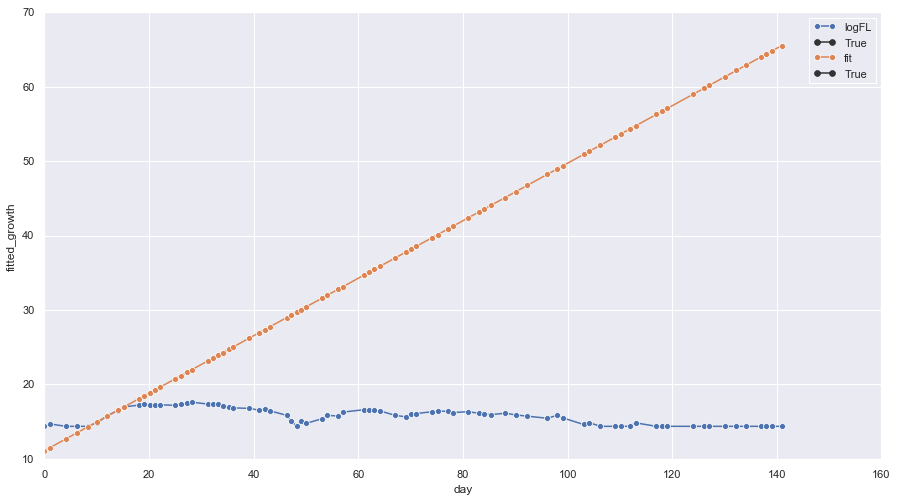

In [73]:
sns.set(rc={'figure.figsize':(15,8)})
es = 'e3, 8B'
d = df.loc[df.experiment_sample == es].reset_index()
d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
sns.lineplot(data=d,
             x='day', y='logcells',  style=True, markers=True,label='logFL')
sns.lineplot(data=d,
    x='day', y='fitted_growth',  style=True, markers=True,label='fit')

#sns.lineplot(data=d, x='day', y='first_deriviative',  style=True, markers=True,label='1')
#sns.lineplot(data=d, x='day', y='second_deriviative',  style=True, markers=True,label='2')

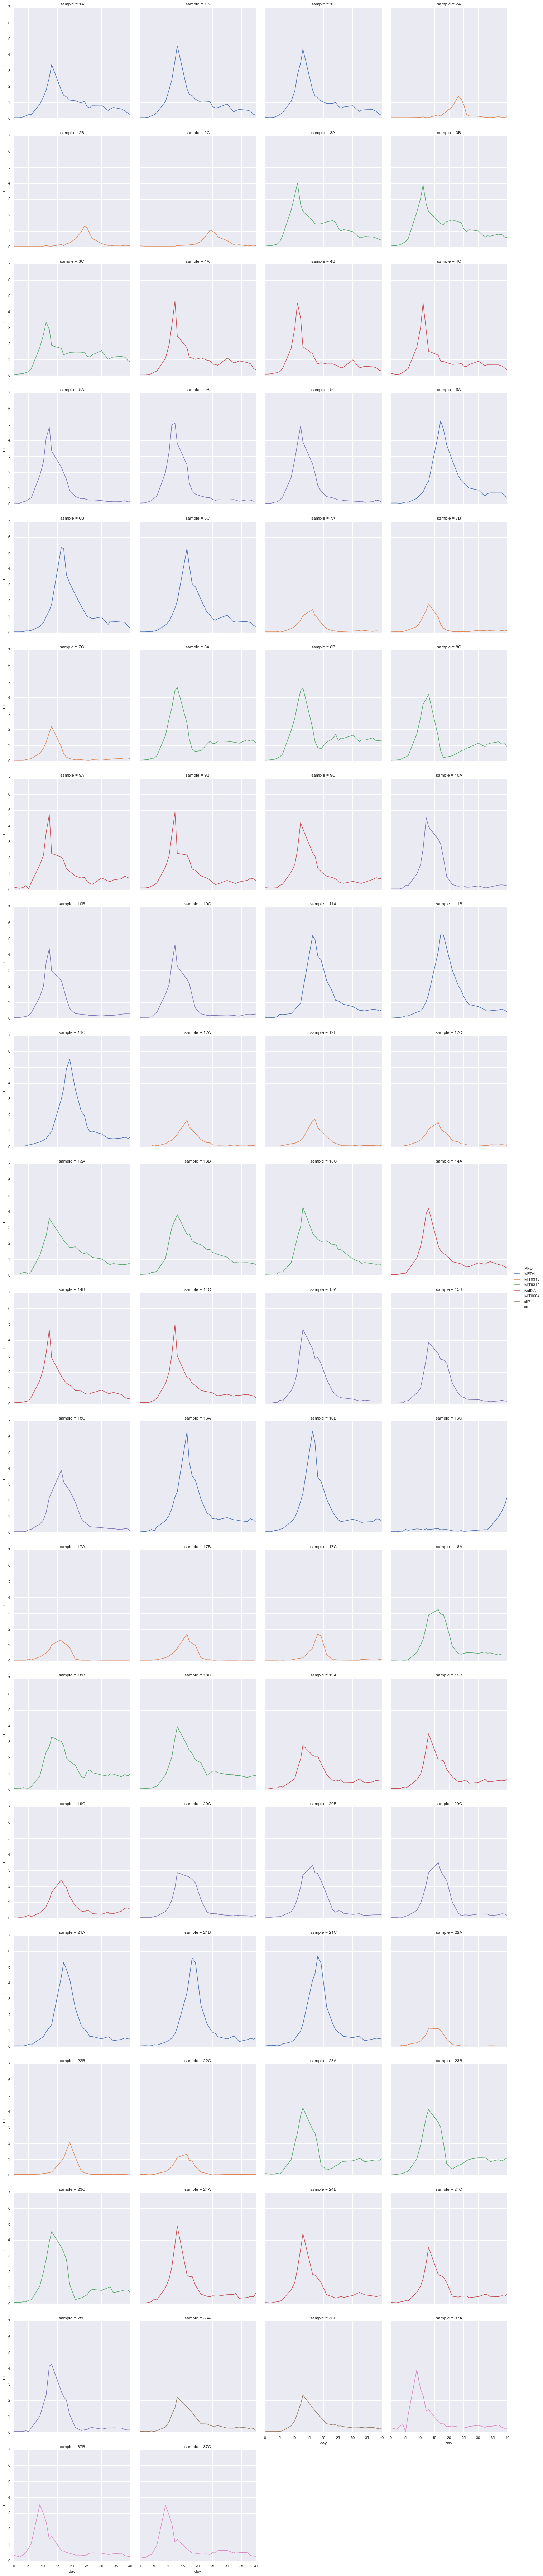

In [74]:
sns.relplot(data=df.loc[df.experiment == 'e2'], x='day', y='FL', 
            col='sample', hue='PRO', col_wrap=4, kind='line')

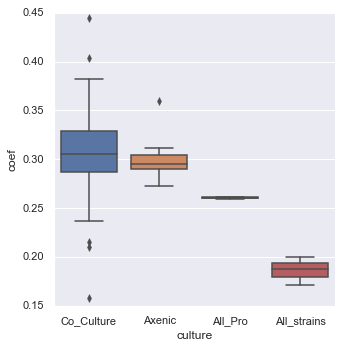

In [75]:
sns.catplot(data=lagsdf.loc[lagsdf.experiment == 'e1'],
            x='culture', y='coef', kind='box',
           )

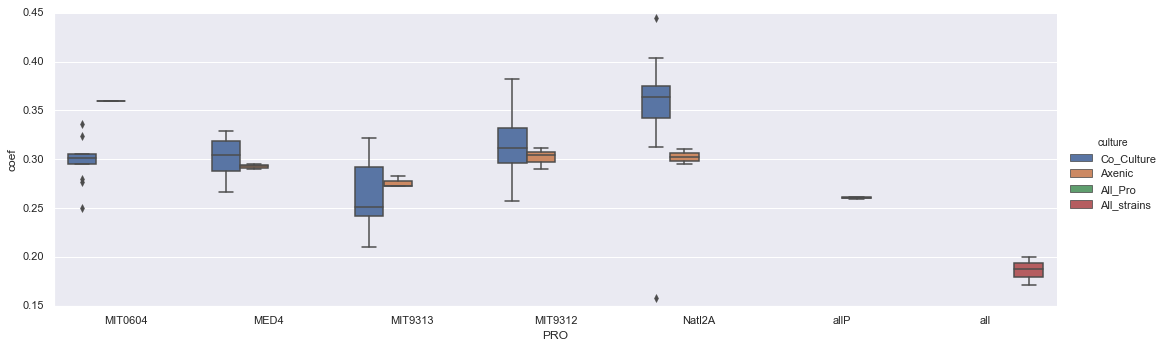

In [76]:
sns.catplot(data=lagsdf.loc[lagsdf.experiment == 'e1'],
            hue='culture', y='coef', kind='box', x='PRO', aspect=3,
           )